In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import missingno as msno
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 145)
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec
import plotly.express as px

# Data preprocessing and wrangling

In [22]:
data=pd.read_csv('data.csv')

Original UFC dataset obtained fron Kaggle. It describes the MMA fights between a fighter in the red corner and the counterpart in the blue corner.

In [23]:
data

R_fighter       B_fighter               Referee        date  \
0             Henry Cejudo   Marlon Moraes          Marc Goddard  2019-06-08   
1     Valentina Shevchenko     Jessica Eye       Robert Madrigal  2019-06-08   
2            Tony Ferguson  Donald Cerrone       Dan Miragliotta  2019-06-08   
3            Jimmie Rivera        Petr Yan       Kevin MacDonald  2019-06-08   
4              Tai Tuivasa   Blagoy Ivanov       Dan Miragliotta  2019-06-08   
...                    ...             ...                   ...         ...   
5139        Gerard Gordeau    Kevin Rosier  Joao Alberto Barreto  1993-11-12   
5140          Ken Shamrock   Patrick Smith  Joao Alberto Barreto  1993-11-12   
5141          Royce Gracie   Art Jimmerson  Joao Alberto Barreto  1993-11-12   
5142          Kevin Rosier    Zane Frazier  Joao Alberto Barreto  1993-11-12   
5143        Gerard Gordeau      Teila Tuli  Joao Alberto Barreto  1993-11-12   

                    location Winner  title_bout       weight_class  \
0     Chicago, Illinois, USA    Red        True       Bantamweight   
1     Chicago, Illinois, USA    Red        True  Women's Flyweight   
2     Chicago, Illinois, USA    Red       False        Lightweight   
3     Chicago, Illinois, USA   Blue       False       Bantamweight   
4     Chicago, Illinois, USA   Blue       False        Heavyweight   
...                      ...    ...         ...                ...   
5139   Denver, Colorado, USA    Red       False        Open Weight   
5140   Denver, Colorado, USA    Red       False        Open Weight   
5141   Denver, Colorado, USA    Red       False        Open Weight   
5142   Denver, Colorado, USA    Red       False        Open Weight   
5143   Denver, Colorado, USA    Red       False        Open Weight   

      no_of_rounds  B_current_lose_streak  B_current_win_streak  B_draw  \
0                5                    0.0                   4.0     0.0   
1                5                    0.0                   3.0     0.0   
2                3                    0.0                   3.0     0.0   
3                3                    0.0                   4.0     0.0   
4                3                    0.0                   1.0     0.0   
...            ...                    ...                   ...     ...   
5139             1                    0.0                   1.0     0.0   
5140             1                    0.0                   0.0     0.0   
5141             1                    0.0                   0.0     0.0   
5142             1                    0.0                   0.0     0.0   
5143             1                    0.0                   0.0     0.0   

      B_avg_BODY_att  B_avg_BODY_landed  B_avg_CLINCH_att  \
0           9.200000           6.000000          0.200000   
1          14.600000           9.100000         11.800000   
2          15.354839          11.322581          6.741935   
3          17.000000          14.000000         13.750000   
4          17.000000          14.500000          2.500000   
...              ...                ...               ...   
5139        4.000000           3.000000          9.000000   
5140             NaN                NaN               NaN   
5141             NaN                NaN               NaN   
5142             NaN                NaN               NaN   
5143             NaN                NaN               NaN   

      B_avg_CLINCH_landed  B_avg_DISTANCE_att  B_avg_DISTANCE_landed  \
0                0.000000           62.600000              20.600000   
1                7.300000          124.700000              42.100000   
2                4.387097           84.741935              38.580645   
3               11.000000          109.500000              48.750000   
4                2.000000          201.000000              59.500000   
...                   ...                 ...                    ...   
5139             4.000000           10.000000               4.000000   
5140 

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Columns: 145 entries, R_fighter to R_age
dtypes: bool(1), float64(134), int64(1), object(9)
memory usage: 5.7+ MB


extracting the names of the fighters fron the dataset. some names occur more than once.


In [25]:
fighters=pd.DataFrame(columns=['name'])
red_fighters=list()
blue_fighters=list()

In [26]:
red_fighters=data['R_fighter']
blue_fighters=data['B_fighter']

In [27]:
red_fighters=list(red_fighters)
blue_fighters=list(blue_fighters)


In [28]:
fighters=red_fighters+blue_fighters

In [29]:
len(fighters)

10288

In [30]:
fighters=pd.DataFrame(data=fighters,columns=['name'])

In [31]:
unique_names=fighters['name'].unique()

In [32]:
number_fights=fighters['name'].value_counts()   

In [33]:
fighters_career_stats=pd.DataFrame(columns=['name','number_of_fights'])

getting a list of fighters without repeatition

In [34]:
for u in range(0,len(unique_names)):
    fighters_career_stats=fighters_career_stats.append({'name':number_fights.index[u],'number_of_fights':
                            number_fights[u]},ignore_index=True)

The idea is to create 5 datasets out of the original dataset. the first one is dataset that describes the career of each fighter, the number of fights, the length of their career and other dimensions that will be later used to answer the analytical questions


In [35]:
fighters_career_stats

name number_of_fights
0          Jim Miller               32
1      Donald Cerrone               32
2     Jeremy Stephens               30
3     Andrei Arlovski               29
4     Michael Bisping               29
...               ...              ...
1910   Stefan Sekulic                1
1911     Houston Dorr                1
1912      Mark Hughes                1
1913  John Polakowski                1
1914      Mike Grundy                1

[1915 rows x 2 columns]

getting the number of victories for each fighter from the original dataset

In [36]:
fighters_career_stats['victories']=0

In [37]:
list_fighters=list(fighters_career_stats['name'])

each fighter could be either in the red or blue corner, the loop below gets the number of occurences where the fighter is victorious

In [38]:
for fighter in list_fighters:
    victories=len(data[((data['B_fighter']==fighter) & (data['Winner']=='Blue'))|
     ((data['R_fighter']==fighter) & (data['Winner']=='Red'))])
    fighters_career_stats.loc[fighters_career_stats['name']==fighter,'victories']=victories

In [39]:
def win_rate(cols):
    #takes the number of fights and the victories and return a percentage numer of victories
    total_fights=cols[0]
    wins=cols[1]
    winrate=(wins*100)/total_fights
    return round(winrate,2)

In [40]:
fighters_career_stats['win_rate']=0

In [41]:
fighters_career_stats['win_rate']=fighters_career_stats[['number_of_fights','victories']].apply(win_rate,axis=1)

In [42]:
fighters_career_stats

name number_of_fights  victories  win_rate
0          Jim Miller               32         19     59.38
1      Donald Cerrone               32         23     71.88
2     Jeremy Stephens               30         15     50.00
3     Andrei Arlovski               29         16     55.17
4     Michael Bisping               29         20     68.97
...               ...              ...        ...       ...
1910   Stefan Sekulic                1          0      0.00
1911     Houston Dorr                1          0      0.00
1912      Mark Hughes                1          1    100.00
1913  John Polakowski                1          0      0.00
1914      Mike Grundy                1          1    100.00

[1915 rows x 4 columns]

Draws are a possible outcome of a fight

In [43]:
data[data['B_draw']==0].head()

R_fighter       B_fighter          Referee        date  \
0          Henry Cejudo   Marlon Moraes     Marc Goddard  2019-06-08   
1  Valentina Shevchenko     Jessica Eye  Robert Madrigal  2019-06-08   
2         Tony Ferguson  Donald Cerrone  Dan Miragliotta  2019-06-08   
3         Jimmie Rivera        Petr Yan  Kevin MacDonald  2019-06-08   
4           Tai Tuivasa   Blagoy Ivanov  Dan Miragliotta  2019-06-08   

                 location Winner  title_bout       weight_class  no_of_rounds  \
0  Chicago, Illinois, USA    Red        True       Bantamweight             5   
1  Chicago, Illinois, USA    Red        True  Women's Flyweight             5   
2  Chicago, Illinois, USA    Red       False        Lightweight             3   
3  Chicago, Illinois, USA   Blue       False       Bantamweight             3   
4  Chicago, Illinois, USA   Blue       False        Heavyweight             3   

   B_current_lose_streak  B_current_win_streak  B_draw  B_avg_BODY_att  \
0                    0.0                   4.0     0.0        9.200000   
1                    0.0                   3.0     0.0       14.600000   
2                    0.0                   3.0     0.0       15.354839   
3                    0.0                   4.0     0.0       17.000000   
4                    0.0                   1.0     0.0       17.000000   

   B_avg_BODY_landed  B_avg_CLINCH_att  B_avg_CLINCH_landed  \
0           6.000000          0.200000             0.000000   
1           9.100000         11.800000             7.300000   
2          11.322581          6.741935             4.387097   
3          14.000000         13.750000            11.000000   
4          14.500000          2.500000             2.000000   

   B_avg_DISTANCE_att  B_avg_DISTANCE_landed  B_avg_GROUND_att  \
0           62.600000              20.600000          2.600000   
1          124.700000              42.100000          2.400000   
2           84.741935              38.580645          5.516129   
3          109.500000              48.750000         13.000000   
4          201.000000              59.500000          0.000000   

   B_avg_GROUND_landed  B_avg_HEAD_att  B_avg_HEAD_landed  B_avg_KD  \
0             2.000000       48.600000          11.200000  0.800000   
1             1.900000      112.000000          32.000000  0.000000   
2             3.806452       67.645161          23.258065  0.645161   
3            10.500000      116.250000          53.750000  0.500000   
4             0.000000      184.500000          45.000000  0.000000   

   B_avg_LEG_att  B_avg_LEG_landed  B_avg_PASS  B_avg_REV  B_avg_SIG_STR_att  \
0            7.6          5.400000    0.400000   0.000000              65.40   
1           12.3         10.200000    0.800000   0.000000             138.90   
2           14.0         12.193548    0.935484   0.096774              97.00   
3            3.0          2.500000    0.500000   0.250000             136.25   
4            2.0          2.000000    0.000000   0.000000             203.50   

   B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_att  \
0             22.600000           0.466000       0.400000       0.80000   
1             51.300000           0.399000       0.700000       1.00000   
2             46.774194           0.496129       0.354839       2.16129   
3             70.250000           0.550000       0.250000       2.50000   
4             61.500000           0.310000       0.000000       0.00000   

   B_avg_TD_landed  B_avg_TD_pct  B_avg_TOTAL_STR_att  B_avg_TOTAL_STR_landed  \
0         0.200000      0.100000            66.400000               23.600000   
1         0.500000      0.225000           158.700000               69.600000   
2         0.677419      0.295484           103.709677               52.548387   
3         1.250000      0.287500           154.750000               86.750000   
4         0.000000      0.000000           204.000000               62.000000   

   B_longest_win_streak  B_

applying the same process to extract number of draws and defeats

In [45]:
fighters_career_stats['Draws']=0


In [46]:
for fighter in list_fighters:
    draws=len(data[((data['B_fighter']==fighter) & (data['Winner']=='Draw')) |
    ((data['R_fighter']==fighter) & (data['Winner']=='Draw'))])
    fighters_career_stats.loc[fighters_career_stats['name']==fighter,'Draws']=draws
    
    

In [47]:
fighters_career_stats['defeats']=0

In [55]:
def get_defeats(cols):
    #calculates the number of defeats from draws and victories
    total_fights=cols[0]
    wins=cols[1]
    draws=cols[2]
    defeats=total_fights-(wins+draws)
    return defeats

In [49]:
fighters_career_stats['defeats']=fighters_career_stats[['number_of_fights','victories','Draws']].apply(get_defeats,axis=1)

In [50]:
fighters_career_stats

name number_of_fights  victories  win_rate  Draws  defeats
0          Jim Miller               32         19     59.38      1       12
1      Donald Cerrone               32         23     71.88      0        9
2     Jeremy Stephens               30         15     50.00      0       15
3     Andrei Arlovski               29         16     55.17      1       12
4     Michael Bisping               29         20     68.97      0        9
...               ...              ...        ...       ...    ...      ...
1910   Stefan Sekulic                1          0      0.00      0        1
1911     Houston Dorr                1          0      0.00      0        1
1912      Mark Hughes                1          1    100.00      0        0
1913  John Polakowski                1          0      0.00      0        1
1914      Mike Grundy                1          1    100.00      0        0

[1915 rows x 6 columns]

In [51]:
fighters_career_stats['draws_rate']=0

In [52]:
def draws_rate(cols):
    total_fights=cols[0]
    draws=cols[1]
    rate=(draws*100)/total_fights
    return (round(rate,2))

In [53]:
fighters_career_stats['draws_rate']=fighters_career_stats[['number_of_fights','Draws']].apply(draws_rate,axis=1)

In [54]:
fighters_career_stats['loss_rate']=0

In [56]:
def loss_rate(cols):
    #takes the number of fights and the victories and return a percentage numer of victories
    total_fights=cols[0]
    loss=cols[1]
    rate=(loss*100)/total_fights
    return (round(rate,2))

In [57]:
fighters_career_stats['loss_rate']=fighters_career_stats[['number_of_fights','defeats']].apply(loss_rate,axis=1)

In [58]:
fighters_career_stats.columns

Index(['name', 'number_of_fights', 'victories', 'win_rate', 'Draws', 'defeats',
       'draws_rate', 'loss_rate'],
      dtype='object')

In [59]:
def plot_fighters_result(name):
    #Draws a pie chart displaying the percentage of wins/loss/draws of any given fighter
    wins=fighters_career_stats.loc[fighters_career_stats['name']==name,'win_rate']
    losses=fighters_career_stats.loc[fighters_career_stats['name']==name,'loss_rate']
    draws=fighters_career_stats.loc[fighters_career_stats['name']==name,'draws_rate']

    labels = ['wins', 'losses', 'draws']
    proportions = [float(wins),float(losses),float(draws)]

    separate = (0.15, 0.15, 0.15)  
    colors=['#d2ff4d','#ff9966','#ccccb3']
    fig1, ax1 = plt.subplots()
    ax1.pie(proportions, explode=separate, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90,pctdistance=0.81, textprops={'fontsize': 13},colors=colors)    
    #covering the center of the pie chart with a white circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    ax1.set_title(name,fontsize=25,y=-0.10)
    ax1.axis('equal')  
    plt.tight_layout()
    plt.show()


the second dataset describe the physical characteristics of each fighters

In [60]:
fighters_physical_attributes=pd.DataFrame()

In [61]:
fighters_physical_attributes['name']=fighters_career_stats['name']

In [62]:
fighters_physical_attributes

name
0          Jim Miller
1      Donald Cerrone
2     Jeremy Stephens
3     Andrei Arlovski
4     Michael Bisping
...               ...
1910   Stefan Sekulic
1911     Houston Dorr
1912      Mark Hughes
1913  John Polakowski
1914      Mike Grundy

[1915 rows x 1 columns]

In [66]:
fighters_physical_attributes['height']=0

to extract the height from the original dataset, the loop below gets the height if the fighter is red and similarly if they are blue, then the mean of the two columns is rendered in the height column

In [67]:
for name in list_fighters:
    height_R=list(data.loc[data['R_fighter']==name,'R_Height_cms'])
    height_B=list(data.loc[data['B_fighter']==name,'B_Height_cms'])
    height=height_R+height_B
    fighters_physical_attributes.loc[fighters_physical_attributes['name']==name,'height']=round(np.nanmean(height),2)

In [68]:
fighters_physical_attributes

name  height
0          Jim Miller  172.72
1      Donald Cerrone  185.42
2     Jeremy Stephens  172.72
3     Andrei Arlovski  190.50
4     Michael Bisping  185.42
...               ...     ...
1910   Stefan Sekulic  182.88
1911     Houston Dorr  185.42
1912      Mark Hughes  175.26
1913  John Polakowski  177.80
1914      Mike Grundy  170.18

[1915 rows x 2 columns]

the original dataset contains missing values, in order to resolve the issue, either web scraping or imputations are necessary. however, the original dataset was scraped from the web, so it is unlikely to find the missing values in one source.

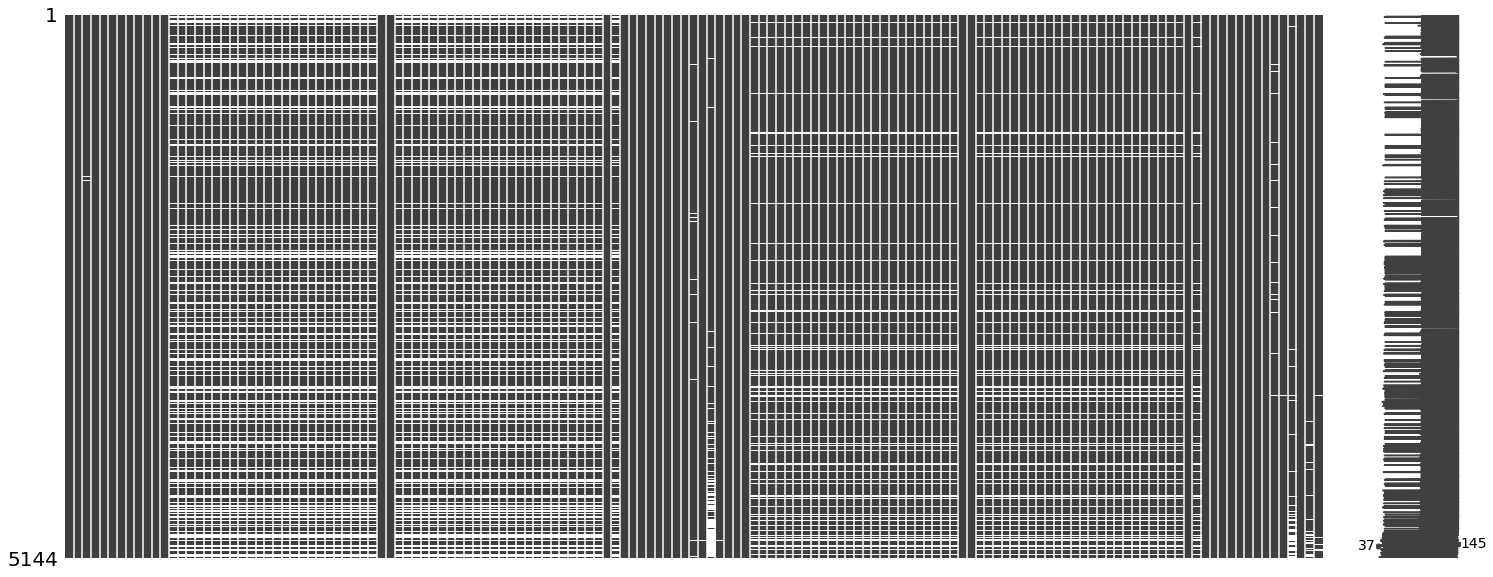

In [69]:
msno.matrix(data)

In [70]:
fighters_missing_height=list(fighters_physical_attributes[fighters_physical_attributes['height'].isnull()]['name'])

In [71]:
#Since the number of missing values in Height column is small, i searched multiple websites to find 
#the missing heights
heights_obtained_from_research={
    'Edward Faaloloto':175,
    'Frank Caracci':172.72,
    'Sam Fulton':188,
    'Kennedy Nzechukwu':195.5,
    'Frank Hamaker':188,
    'Tom Blackledge':182.88,
    'Felix Lee Mitchell':180,}


In [72]:
#replacing missing height with the dictionary above
for fighter in heights_obtained_from_research:
    fighters_physical_attributes.loc[fighters_physical_attributes['name']==fighter,
                                    'height']=heights_obtained_from_research[fighter]

the remaining 4 missing values were replaced with the mean of the population

In [73]:
fighters_physical_attributes.loc[fighters_physical_attributes['height'].isnull(),'height']=fighters_physical_attributes['height'].mean()

In [75]:
fighters_physical_attributes['weight']=0

In [77]:
for name in list_fighters:
    weight_R=list(data.loc[data['R_fighter']==name,'R_Weight_lbs'])
    weight_B=list(data.loc[data['B_fighter']==name,'B_Weight_lbs'])
    weight=weight_R+weight_B
    fighters_physical_attributes.loc[fighters_physical_attributes['name']==name,'weight']=round(np.nanmean(weight),2)

In [78]:
fighters_physical_attributes[fighters_physical_attributes['weight'].isnull()]

name     height  weight
1544         Jack Nilson  178.97731     NaN
1619   Kennedy Nzechukwu  195.50000     NaN
1690          Ray Wizard  178.97731     NaN
1740       Frank Caracci  172.72000     NaN
1767       Noe Hernandez  178.97731     NaN
1785       Frank Hamaker  188.00000     NaN
1797          Sam Fulton  188.00000     NaN
1849      Saeed Hosseini  178.97731     NaN
1857  Felix Lee Mitchell  180.00000     NaN

In [80]:
#replacing missing weight values with means
fighters_physical_attributes.loc[fighters_physical_attributes['weight'].isnull(),'weight']=fighters_physical_attributes['weight'].mean()

applying same process as before to extract the reach of the fighters, the reach also called the wingspan, refers to the distance between left arm fingertip to right arm fingertip. 

In [81]:
fighters_physical_attributes['reach']=0

In [83]:
for name in list_fighters:
    reach_R=list(data.loc[data['R_fighter']==name,'R_Reach_cms'])
    reach_B=list(data.loc[data['B_fighter']==name,'B_Reach_cms'])
    reach=reach_R+reach_B
    fighters_physical_attributes.loc[fighters_physical_attributes['name']==name,'reach']=round(np.nanmean(reach),2)

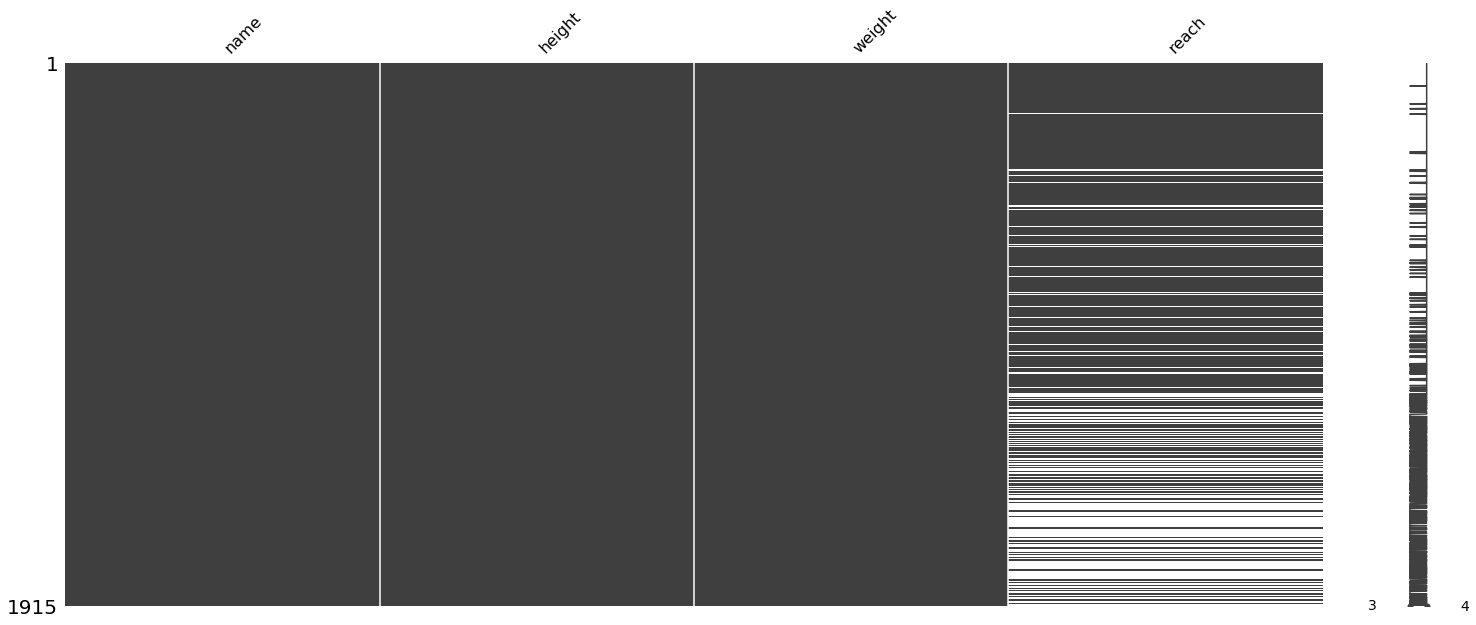

In [85]:
msno.matrix(fighters_physical_attributes)

In [90]:
len(fighters_physical_attributes[fighters_physical_attributes['reach'].isnull()].index)

484

there are 484 fighters that are missing the value reach. The reach of fighters depends on the length of their limbs, whic hare proportional with their height. therefore we can apply linear regression to impute the missing values

In [92]:
#the correlation between reach and height, which is important to determine whether the two variable have a relationship
fighters_physical_attributes[['reach','height']].corr()

reach    height
reach   1.000000  0.881296
height  0.881296  1.000000

there is a linear relationship between reach and height.

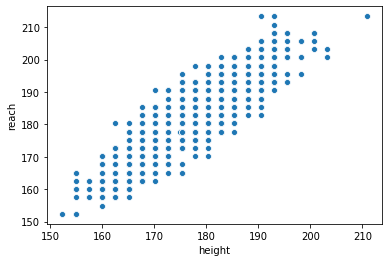

In [94]:
sns.scatterplot(x=fighters_physical_attributes['height'],y=fighters_physical_attributes['reach'])
plt.show()

predictors_height and missing_reach contain respectively the height values that are going to be used as predictors and the missing values of reach. missing_reach is a placeholder for the predicted values

In [95]:
predictors_height=fighters_physical_attributes[fighters_physical_attributes['reach'].isnull()]['height']

In [96]:
missing_reach=fighters_physical_attributes[fighters_physical_attributes['reach'].isnull()]['reach']

X hold the values of height where reach is not missing. 

In [99]:
X=fighters_physical_attributes[fighters_physical_attributes['reach'].isnull()==False]['height']

In [100]:
Y=fighters_physical_attributes[fighters_physical_attributes['reach'].isnull()==False]['reach']

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

performing cross validation to ensure that the model will not overfit on training data

In [102]:
 X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

In [103]:
LR=LinearRegression()

Sklearn's Linear Regression with one predictor, requires the training set to be a 2D matrix

In [104]:
X_train_matrix=X_train.values.reshape(-1,1)

In [105]:
LR.fit(X_train_matrix,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [106]:
LR.score(X_train_matrix,y_train)

0.7788586942347641

the coefficient of determination is 0.78 and we can safely assume that the model will fit the population dataset as 78% of changes in reach are explained by changes in height

In [107]:
predictions=LR.predict(X_test.values.reshape(-1,1))

In [109]:
np.mean((predictions-y_test)**2)

24.475637061559176

In [111]:
reach=LR.predict(predictors_height.values.reshape(-1,1))

In [113]:
missing_reach=reach

In [114]:
fighters_physical_attributes.loc[fighters_physical_attributes['reach'].isnull(),'reach']=missing_reach

plotting the imputed reach values 

Text(0.5, 1.0, 'linear regression on height and weight')

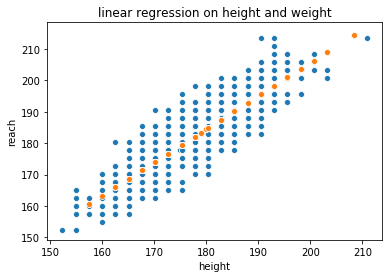

In [533]:
sns.scatterplot(fighters_physical_attributes['height'],fighters_physical_attributes['reach'])
sns.scatterplot(predictors_height,missing_reach)
plt.title('linear regression on height and weight')

adding the gender in the physical attributes dataset by finding in which weight class does the fighter belong in the original dataset

In [116]:
fighters_physical_attributes['gender']=0

In [117]:
female_weight_divisions=["Women's Strawweight","Women's Bantamweight","Women's Flyweight","Women's Featherweight"]

In [119]:
#0 for females 1 for males
for name in list_fighters:
    weight_class=list(data[(data['R_fighter']==name) | (data['B_fighter']==name)]['weight_class'])
    if weight_class[0] in female_weight_divisions:
        gender=0
    else:
        gender=1
    fighters_physical_attributes.loc[fighters_physical_attributes['name']==name,['gender']]=gender

stereotypically UFC is a sport dominated by males.

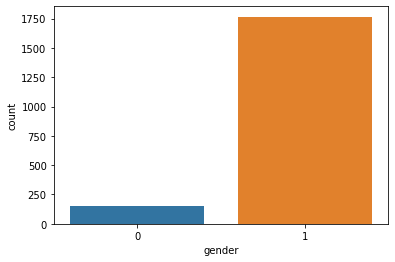

In [143]:
sns.countplot(x='gender',data=fighters_physical_attributes)
plt.show()


exploring the fighters_physical_attributes dataset for outliers or mistakes

In [148]:
fighters_physical_attributes.describe()

height       weight        reach       gender
count  1915.000000  1915.000000  1915.000000  1915.000000
mean    178.977310   173.048269   183.307620     0.922193
std       8.650309    40.637138    10.045250     0.267937
min     152.400000   115.000000   152.400000     0.000000
25%     172.720000   145.000000   177.800000     1.000000
50%     180.340000   170.000000   182.880000     1.000000
75%     185.420000   185.000000   190.500000     1.000000
max     210.820000   770.000000   214.389825     1.000000

converting weight unit from lbs to KG for the sake of convenience.

In [149]:
fighters_physical_attributes['weight_kg']=0

In [150]:
fighters_physical_attributes['weight_kg']=fighters_physical_attributes['weight'].apply(lambda x:x*0.453)

In [151]:
fighters_physical_attributes

name  height  weight       reach  gender  weight_kg
0          Jim Miller  172.72   155.0  180.340000       1     70.215
1      Donald Cerrone  185.42   155.0  185.420000       1     70.215
2     Jeremy Stephens  172.72   145.0  180.340000       1     65.685
3     Andrei Arlovski  190.50   240.0  195.580000       1    108.720
4     Michael Bisping  185.42   185.0  190.500000       1     83.805
...               ...     ...     ...         ...     ...        ...
1910   Stefan Sekulic  182.88   170.0  190.500000       1     77.010
1911     Houston Dorr  185.42   210.0  190.155904       1     95.130
1912      Mark Hughes  175.26   205.0  179.385273       1     92.865
1913  John Polakowski  177.80   155.0  182.077931       1     70.215
1914      Mike Grundy  170.18   145.0  182.880000       1     65.685

[1915 rows x 6 columns]

In [152]:
fighters_physical_attributes.drop(['weight'],inplace=True,axis=1)

In [153]:
fighters_physical_attributes['reach']=fighters_physical_attributes['reach'].apply(lambda x:round(x,3))

the distrbution of weight_kg variable shows some right skeweness which is indicative of the presence of outliers

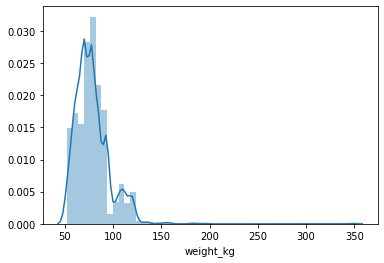

In [162]:
sns.distplot(fighters_physical_attributes['weight_kg'])
plt.show()


getting the 99th percentile to find the outliers

In [156]:
q_weight=fighters_physical_attributes['weight_kg'].quantile(0.99)

In [163]:
fighters_physical_attributes[fighters_physical_attributes['weight_kg']>=q_weight]

name  height    reach  gender  weight_kg
422         Paul Varelans  203.20  209.005       1    135.900
814        Scott Ferrozzo  180.34  184.771       1    146.319
830          Ron Waterman  187.96  192.849       1    126.840
1178        Steven Graham  185.42  190.156       1    131.370
1203           Dan Bobish  187.96  192.849       1    156.285
1211        Tedd Williams  185.42  190.156       1    124.575
1301        Andre Roberts  187.96  192.849       1    156.285
1452         Kevin Rosier  193.04  198.234       1    124.575
1541       Thomas Ramirez  185.42  190.156       1    185.730
1577      Harry Moskowitz  195.58  200.927       1    124.575
1642       Julian Sanchez  190.50  195.541       1    135.900
1661          Chris Condo  182.88  187.463       1    151.755
1732           Teila Tuli  182.88  187.463       1    194.790
1747           Koji Kitao  200.66  206.312       1    158.550
1751         Gerry Harris  203.20  209.005       1    122.310
1793        David Levicki  195.58  200.927       1    124.575
1855           Tony Halme  190.50  195.541       1    135.900
1867           John Matua  187.96  192.849       1    181.200
1872  Emmanuel Yarborough  203.20  209.005       1    348.810
1878             Jon Hess  200.66  206.312       1    133.635

upon inspection of the dataset, the weight of Emmanuel Yarborough is inacurate and that is due to one of the drawbacks of web scraping which is the retrieval of up to date data. Emmanuel Yarborough reached 350 for his guiness world record and not while he was a UFC fighter

In [164]:
fighters_physical_attributes.loc[fighters_physical_attributes['name']=='Emmanuel Yarborough',['weight_kg']]=270

adding features to fighters_career_stats dataset

adding career length of each fighter by computing the difference between the date of the first fight and the date of the last fight

In [165]:
import datetime

In [166]:
fighters_career_stats['date_first_fight']=0
fighters_career_stats['date_last_fight']=0

In [168]:
def get_first_fight(name):
    #takes a fighter's name and return the date of their first fight
    dates=list(data[(data['R_fighter']==name)|(data['B_fighter']==name)]['date'])
    date_format = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in dates]
    date_format.sort()
    sorted_dates = [datetime.datetime.strftime(date, "%Y-%m-%d") for date in date_format]
    return sorted_dates[0]
def get_last_fight(name):
    #takes a fighter's name and return the date of their first fight
    dates=list(data[(data['R_fighter']==name)|(data['B_fighter']==name)]['date'])
    date_format = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in dates]
    date_format.sort()
    sorted_dates = [datetime.datetime.strftime(date, "%Y-%m-%d") for date in date_format]
    return sorted_dates[-1]

In [169]:
fighters_career_stats['date_first_fight']=fighters_career_stats['name'].apply(get_first_fight)
fighters_career_stats['date_last_fight']=fighters_career_stats['name'].apply(get_last_fight)

In [170]:
fighters_career_stats['career_length_in_years']=0

In [171]:
def career_length(cols):
    #takes the date of the first and last fight as arguments and compute the length of career
    date_format = "%Y-%m-%d"
    first=cols[0]
    last=cols[1]
    first_fight = datetime.datetime.strptime(first, date_format)
    last_fight = datetime.datetime.strptime(last, date_format)
    in_days=last_fight-first_fight
    number_days=in_days.days
    years=number_days/365
    return round(years,2)
    

In [172]:
fighters_career_stats['career_length_in_years']=fighters_career_stats[['date_first_fight','date_last_fight']].apply(career_length,axis=1)

adding longest win streak to career stats dataset

In [179]:
fighters_career_stats['longest_win_streak']=0

In [180]:
for name in list_fighters:
    win_streak_R=list(data.loc[data['R_fighter']==name,'R_longest_win_streak'])
    win_streak_B=list(data.loc[data['B_fighter']==name,'B_longest_win_streak'])
    win_streak=win_streak_R + win_streak_B
    fighters_career_stats.loc[fighters_career_stats['name']==name,'longest_win_streak']=max(win_streak)


In UFC there are 6 scenarios to determine the winner as shows below.

In [182]:
fighters_career_stats['win_by_Decision_Majority']=0
fighters_career_stats['win_by_Decision_split']=0
fighters_career_stats['win_by_Decision_Unanimous']=0
fighters_career_stats['win_by_KO']=0
fighters_career_stats['win_by_TKO_Doctor_stoppage']=0
fighters_career_stats['win_by_Submission']=0



following the same previous method for data extractiong, we get for each fighter the ways they previously won

In [184]:
for name in list_fighters:
    win_majority_R=list(data.loc[data['R_fighter']==name,'R_win_by_Decision_Majority'])
    win_majority_B=list(data.loc[data['B_fighter']==name,'B_win_by_Decision_Majority'])
    win_majority=win_majority_R + win_majority_B
    fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_Decision_Majority']=max(win_majority)
    
    win_split_R=list(data.loc[data['R_fighter']==name,'R_win_by_Decision_Split'])
    win_split_B=list(data.loc[data['B_fighter']==name,'B_win_by_Decision_Split'])
    win_split=win_split_R + win_split_B
    fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_Decision_split']=max(win_split)
    
    win_unanimous_R=list(data.loc[data['R_fighter']==name,'R_win_by_Decision_Unanimous'])
    win_unanimous_B=list(data.loc[data['B_fighter']==name,'B_win_by_Decision_Unanimous'])
    win_unanimous=win_unanimous_R + win_unanimous_B
    fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_Decision_Unanimous']=max(win_unanimous)
    
    win_ko_R=list(data.loc[data['R_fighter']==name,'R_win_by_KO/TKO'])
    win_ko_B=list(data.loc[data['B_fighter']==name,'B_win_by_KO/TKO'])
    win_ko=win_ko_R + win_ko_B
    fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_KO']=max(win_ko)
    
    win_TKODS_R=list(data.loc[data['R_fighter']==name,'R_win_by_TKO_Doctor_Stoppage'])
    win_TKODS_B=list(data.loc[data['B_fighter']==name,'B_win_by_TKO_Doctor_Stoppage'])
    win_TKODS=win_TKODS_R + win_TKODS_B
    fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_TKO_Doctor_stoppage']=max(win_TKODS)
    
    win_sub_R=list(data.loc[data['R_fighter']==name,'R_win_by_Submission'])
    win_sub_B=list(data.loc[data['B_fighter']==name,'B_win_by_Submission'])
    win_sub=win_sub_R + win_sub_B
    fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_Submission']=max(win_sub)



In [200]:
def plot_fighters_career_win_by(name):
    #takes the name of a fighter to plot a pie chart that illustrates the win_by methods
    majority=fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_Decision_Majority']
    split=fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_Decision_split']
    unanimous=fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_Decision_Unanimous']
    KO=fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_KO']
    stoppage=fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_TKO_Doctor_stoppage']
    submission=fighters_career_stats.loc[fighters_career_stats['name']==name,'win_by_Submission']

    
    labels = ['majority', 'split', 'unanimous','KO','Doctor Stoppage or TKO','Submission']
    #the size of slices
    proportions = [float(majority),float(split),float(unanimous),float(KO),float(stoppage),float(submission)]
    # separating the slices
    separate = (0.2, 0.2, 0.2,0.2,0.2,0.2)  

    fig1, ax1 = plt.subplots()
    ax1.pie(proportions, explode=separate, autopct='%1.1f%%',
            shadow=True, startangle=90,pctdistance=0.81, textprops={'fontsize': 13})   
    ax1.legend(labels,
          title="win by",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))


    #drawing a white cirle on the center of the pie chart
    
    centre_circle = plt.Circle((0,0),0.75,fc='white')
    fig= plt.gcf()
    fig.gca().add_artist(centre_circle)
    ax1.set_title(name,fontsize=25,y=-0.10)
    ax1.axis('equal')  
    plt.tight_layout()
    plt.show()
    

for Jim Miller his common way of winning is to win by submission.

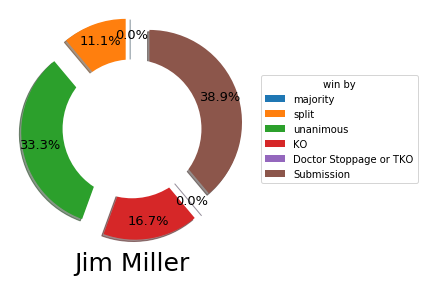

In [576]:
plot_fighters_career_win_by('Jim Miller')

what is the most common way of winning?

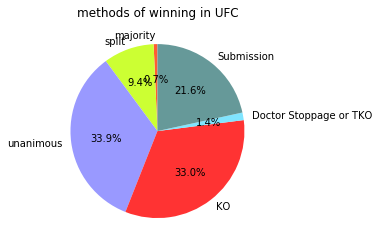

In [577]:
labels = ['majority', 'split', 'unanimous','KO','Doctor Stoppage or TKO','Submission']
proportions=[fighters_career_stats['win_by_Decision_Majority'].sum(),
             fighters_career_stats['win_by_Decision_split'].sum(),
             fighters_career_stats['win_by_Decision_Unanimous'].sum(),
             fighters_career_stats['win_by_KO'].sum(),
             fighters_career_stats['win_by_TKO_Doctor_stoppage'].sum(),
             fighters_career_stats['win_by_Submission'].sum()]
colors=['#ff5c33','#ccff33','#9999ff','#ff3333','#80e5ff','#669999']
fig1, ax1 = plt.subplots()
ax1.pie(proportions, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,pctdistance=0.60, textprops={'fontsize': 10},colors=colors)
plt.title('methods of winning in UFC')
plt.show()

the most common way of winning is Decision unanimous, a scenario where all judges agree on who won the fight, as opposed decision split which is a scenario where a bigger portion of the judges choose one fighter and the remaining choose the other. the least common way of winning is decision majority, which is a rare scenario in which the third judge does not choose a winner and declares a draw whereas the other two judges choose a winner.

the original dataset describes the events of a fight such as the number of strikes, the numer of strikes landed, where the fighters hit each other and where the fighters missed. fighters_skills will have for each fighter the average of the times the fighter hit their opponent and the remaining statistics

In [207]:
fighters_skills=pd.DataFrame()

In [209]:
fighters_skills['name']=fighters_career_stats['name']
fighters_skills

name
0          Jim Miller
1      Donald Cerrone
2     Jeremy Stephens
3     Andrei Arlovski
4     Michael Bisping
...               ...
1910   Stefan Sekulic
1911     Houston Dorr
1912      Mark Hughes
1913  John Polakowski
1914      Mike Grundy

[1915 rows x 1 columns]

extracting the fights events from original dataset by taking the average of each feature for each fight to obtain a dataset describing the fighters striking skills

In [210]:
for name in list_fighters:
    body_att_R=list(data.loc[data['R_fighter']==name,'R_avg_BODY_att'])
    body_att_B=list(data.loc[data['B_fighter']==name,'B_avg_BODY_att'])
    body_att=body_att_B+body_att_R
    fighters_skills.loc[fighters_skills['name']==name,'body_att']=round(np.nanmean(body_att),3)
    
    body_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_BODY_landed'])
    body_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_BODY_landed'])
    body_att_landed=body_att_landed_R+body_att_landed_B
    fighters_skills.loc[fighters_skills['name']==name,'body_att_landed']=round(np.nanmean(body_att_landed),3)
    
    clinch_R=list(data.loc[data['R_fighter']==name,'R_avg_CLINCH_att'])
    clinch_B=list(data.loc[data['B_fighter']==name,'B_avg_CLINCH_att'])
    clinch=clinch_R+clinch_B
    fighters_skills.loc[fighters_skills['name']==name,'clinch_att']=round(np.nanmean(clinch),3)
    
    clinch_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_CLINCH_landed'])
    clinch_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_CLINCH_landed'])
    clinch_landed=clinch_landed_R+clinch_landed_B
    fighters_skills.loc[fighters_skills['name']==name,'clinch_landed']=round(np.nanmean(clinch_landed),3)
    
    distance_attack_R=list(data.loc[data['R_fighter']==name,'R_avg_DISTANCE_att'])
    distance_attack_B=list(data.loc[data['B_fighter']==name,'B_avg_DISTANCE_att'])
    distance_attack=distance_attack_R+distance_attack_B
    fighters_skills.loc[fighters_skills['name']==name,'distance_att']=round(np.nanmean(distance_attack),3)
    
    distance_attack_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_DISTANCE_landed'])
    distance_attack_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_DISTANCE_landed'])
    distance_landed=distance_attack_landed_R+distance_attack_landed_B
    fighters_skills.loc[fighters_skills['name']==name,'distance_att_landed']=round(np.nanmean(distance_landed),3)
    
    ground_att_R=list(data.loc[data['R_fighter']==name,'R_avg_GROUND_att'])
    ground_att_B=list(data.loc[data['B_fighter']==name,'B_avg_GROUND_att'])
    ground_Att=ground_att_R+ground_att_B
    fighters_skills.loc[fighters_skills['name']==name,'ground_att']=round(np.nanmean(ground_Att))
    
    ground_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_GROUND_landed'])
    ground_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_GROUND_landed'])
    ground_att_landed=ground_att_landed_R+ground_att_landed_B
    fighters_skills.loc[fighters_skills['name']==name,'ground_att_landed']=round(np.nanmean(ground_att_landed))
     
    head_att_R=list(data.loc[data['R_fighter']==name,'R_avg_HEAD_att'])
    head_att_B=list(data.loc[data['B_fighter']==name,'B_avg_HEAD_att'])
    head_att=head_att_R+head_att_B
    fighters_skills.loc[fighters_skills['name']==name,'head_att']=round(np.nanmean(head_att),3)
    
    head_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_HEAD_landed'])
    head_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_HEAD_landed'])
    head_att_landed=head_att_landed_R+head_att_landed_B
    fighters_skills.loc[fighters_skills['name']==name,'head_att_landed']=round(np.nanmean(head_att_landed),3)
    
    leg_att_R=list(data.loc[data['R_fighter']==name,'R_avg_LEG_att'])
    leg_att_B=list(data.loc[data['B_fighter']==name,'B_avg_LEG_att'])
    leg_att=leg_att_R+leg_att_B
    fighters_skills.loc[fighters_skills['name']==name,'leg_att']=round(np.nanmean(leg_att),3)
    
    leg_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_LEG_landed'])
    leg_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_LEG_landed'])
    leg_att_landed=leg_att_landed_R+leg_att_landed_B
    fighters_skills.loc[fighters_skills['name']==name,'leg_att_landed']=round(np.nanmean(leg_att_landed),3)
    
    KD_R=list(data.loc[data['R_fighter']==name,'R_avg_KD'])
    KD_B=list(data.loc[data['B_fighter']==name,'B_avg_KD'])
    KD=KD_R+KD_B
    fighters_skills.loc[fighters_skills['name']==name,'KnockDowns']=round(np.nanmean(KD),3)
    
    pass_R=list(data.loc[data['R_fighter']==name,'R_avg_PASS'])
    pass_B=list(data.loc[data['B_fighter']==name,'B_avg_PASS'])
    passs=pass_R+pass_B
    fighters_skills.loc[fighters_skills['name']==name,'passes']=round(np.nanmean(passs),3)
    
    reversals_R=list(data.loc[data['R_fighter']==name,'R_avg_REV'])
    reversals_B=list(data.loc[data['B_fighter']==name,'B_avg_REV'])
    reversals=reversals_R+reversals_B
    fighters_skills.loc[fighters_skills['name']==name,'reversals']=round(np.nanmean(reversals),3)
    
    submission_att_R=list(data.loc[data['R_fighter']==name,'R_avg_SUB_ATT'])
    submission_att_B=list(data.loc[data['B_fighter']==name,'B_avg_SUB_ATT'])
    submission_att=submission_att_R+submission_att_B
    fighters_skills.loc[fighters_skills['name']==name,'submission_att']=round(np.nanmean(submission_att),3)
    
    td_att_R=list(data.loc[data['R_fighter']==name,'R_avg_TD_att'])
    td_att_B=list(data.loc[data['B_fighter']==name,'B_avg_TD_att'])
    td_att=td_att_R+td_att_B
    fighters_skills.loc[fighters_skills['name']==name,'TD_att']=round(np.nanmean(td_att),3)

    td_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_TD_landed'])
    td_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_TD_landed'])
    td_att_landed=td_att_landed_R+td_att_landed_B
    fighters_skills.loc[fighters_skills['name']==name,'TD_att_landed']=round(np.nanmean(td_att_landed),3)
    

In [216]:
fighters_skills.head()

name  body_att  body_att_landed  clinch_att  clinch_landed  \
0       Jim Miller     7.780            5.053       9.288          5.346   
1   Donald Cerrone    14.035           10.440       5.304          3.189   
2  Jeremy Stephens     7.849            5.750       4.351          3.525   
3  Andrei Arlovski     2.653            1.759       6.131          3.759   
4  Michael Bisping     9.886            7.884      11.479          7.542   

   distance_att  distance_att_landed  ground_att  ground_att_landed  head_att  \
0        52.621               15.552        12.0                7.0    59.913   
1        77.309               37.494         7.0                5.0    58.687   
2        48.906               17.322        17.0               10.0    54.561   
3        41.067               15.096         2.0                1.0    36.954   
4        84.008               29.174        14.0                8.0    94.655   

   head_att_landed  leg_att  leg_att_landed  KnockDowns  passes  reversals  \
0           17.931    6.216           5.063       0.158   2.768      0.205   
1           20.472   16.646          14.279       0.439   1.466      0.062   
2           19.537    7.791           5.609       0.446   0.312      0.541   
3           11.739    9.326           6.465       0.471   0.148      0.005   
4           32.296    5.195           4.531       0.391   1.375      0.191   

   submission_att  TD_att  TD_att_landed  
0           1.963   3.724          1.849  
1           0.386   1.816          0.842  
2           0.419   2.218          1.089  
3           0.418   0.444          0.205  
4           0.600   2.477          1.408

similarly we do the same for the fighter's defensive skills, fighters_defense describes the ability of a fighter to either block or dodge a strike. And also, it shows the number of strikes received by the fighters 

In [217]:
fighters_defense=pd.DataFrame()

In [218]:
fighters_defense['name']=fighters_career_stats['name']

In [219]:
for name in list_fighters:
    opp_body_att_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_BODY_att'])
    opp_body_att_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_BODY_att'])
    opp_body_att=opp_body_att_B+opp_body_att_R
    fighters_defense.loc[fighters_defense['name']==name,'opp_body_att']=round(np.nanmean(opp_body_att),3)
    
    opp_body_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_BODY_landed'])
    opp_body_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_BODY_landed'])
    opp_body_att_landed=opp_body_att_landed_R+opp_body_att_landed_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_body_att_landed']=round(np.nanmean(opp_body_att_landed),3)
    
    opp_clinch_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_CLINCH_att'])
    opp_clinch_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_CLINCH_att'])
    opp_clinch=opp_clinch_R+opp_clinch_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_clinch_att']=round(np.nanmean(opp_clinch),3)
    
    opp_clinch_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_CLINCH_landed'])
    opp_clinch_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_CLINCH_landed'])
    opp_clinch_landed=opp_clinch_landed_R+opp_clinch_landed_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_clinch_landed']=round(np.nanmean(opp_clinch_landed),3)
    
    opp_distance_attack_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_DISTANCE_att'])
    opp_distance_attack_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_DISTANCE_att'])
    opp_distance_attack=opp_distance_attack_R+opp_distance_attack_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_distance_att']=round(np.nanmean(opp_distance_attack),3)
    
    opp_distance_attack_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_DISTANCE_landed'])
    opp_distance_attack_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_DISTANCE_landed'])
    opp_distance_landed=opp_distance_attack_landed_R + opp_distance_attack_landed_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_distance_att_landed']=round(np.nanmean(opp_distance_landed),3)
    
    opp_ground_att_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_GROUND_att'])
    opp_ground_att_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_GROUND_att'])
    opp_ground_Att=opp_ground_att_R + opp_ground_att_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_ground_att']=round(np.nanmean(opp_ground_Att))
    
    opp_ground_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_GROUND_landed'])
    opp_ground_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_GROUND_landed'])
    opp_ground_att_landed=opp_ground_att_landed_R+ opp_ground_att_landed_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_ground_att_landed']=round(np.nanmean(opp_ground_att_landed))
     
    opp_head_att_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_HEAD_att'])
    opp_head_att_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_HEAD_att'])
    opp_head_att=opp_head_att_R+opp_head_att_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_head_att']=round(np.nanmean(opp_head_att),3)
    
    opp_head_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_HEAD_landed'])
    opp_head_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_HEAD_landed'])
    opp_head_att_landed=opp_head_att_landed_R + opp_head_att_landed_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_head_att_landed']=round(np.nanmean(opp_head_att_landed),3)
    
    opp_leg_att_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_LEG_att'])
    opp_leg_att_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_LEG_att'])
    opp_leg_att=opp_leg_att_R + opp_leg_att_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_leg_att']=round(np.nanmean(opp_leg_att),3)
    
    opp_leg_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_LEG_landed'])
    opp_leg_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_LEG_landed'])
    opp_leg_att_landed=opp_leg_att_landed_R + opp_leg_att_landed_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_leg_att_landed']=round(np.nanmean(opp_leg_att_landed),3)
    
    opp_KD_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_KD'])
    opp_KD_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_KD'])
    opp_KD=opp_KD_R + opp_KD_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_KnockDowns']=round(np.nanmean(opp_KD),3)
    
    opp_pass_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_PASS'])
    opp_pass_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_PASS'])
    opp_passs=opp_pass_R + opp_pass_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_passes']=round(np.nanmean(opp_passs),3)
    
    opp_reversals_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_REV'])
    opp_reversals_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_REV'])
    opp_reversals=opp_reversals_R + opp_reversals_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_reversals']=round(np.nanmean(opp_reversals),3)
    
    opp_submission_att_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_SUB_ATT'])
    opp_submission_att_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_SUB_ATT'])
    opp_submission_att=opp_submission_att_R + opp_submission_att_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_submission_att']=round(np.nanmean(opp_submission_att),3)
    
    opp_td_att_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_TD_att'])
    opp_td_att_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_TD_att'])
    opp_td_att=opp_td_att_R + opp_td_att_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_TD_att']=round(np.nanmean(opp_td_att),3)

    opp_td_att_landed_R=list(data.loc[data['R_fighter']==name,'R_avg_opp_TD_landed'])
    opp_td_att_landed_B=list(data.loc[data['B_fighter']==name,'B_avg_opp_TD_landed'])
    opp_td_att_landed=opp_td_att_landed_R + opp_td_att_landed_B
    fighters_defense.loc[fighters_defense['name']==name,'opp_TD_att_landed']=round(np.nanmean(opp_td_att_landed),3)
    
    

In [221]:
fighters_defense.head()

name  opp_body_att  opp_body_att_landed  opp_clinch_att  \
0       Jim Miller         7.962                5.637           6.635   
1   Donald Cerrone        14.209                9.125           5.661   
2  Jeremy Stephens         7.005                4.988           4.473   
3  Andrei Arlovski         2.138                1.639           3.215   
4  Michael Bisping         7.088                4.150           5.889   

   opp_clinch_landed  opp_distance_att  opp_distance_att_landed  \
0              4.047            49.643                   14.798   
1              3.287            83.762                   39.110   
2              3.031            54.715                   18.550   
3              1.726            30.780                    9.744   
4              2.960            63.684                   18.775   

   opp_ground_att  opp_ground_att_landed  opp_head_att  opp_head_att_landed  \
0             6.0                    4.0        52.005               15.007   
1             2.0                    1.0        69.258               28.098   
2             6.0                    4.0        51.671               14.557   
3             6.0                    4.0        33.085               10.231   
4             4.0                    2.0        60.227               14.805   

   opp_leg_att  opp_leg_att_landed  opp_KnockDowns  opp_passes  opp_reversals  \
0        2.471               1.962           0.022       1.222          0.392   
1        7.679               5.901           0.172       0.003          0.035   
2        6.879               5.725           0.071       3.141          0.422   
3        4.329               3.408           0.188       0.785          0.122   
4        6.095               4.654           0.253       1.587          0.160   

   opp_submission_att  opp_TD_att  opp_TD_att_landed  
0               0.556       2.194              1.126  
1               0.271       2.112              0.241  
2               1.478       3.077              1.244  
3               0.181       2.351              0.353  
4               0.488       3.935              1.541

checking for missing data values in fighters_defense and fighters_skills

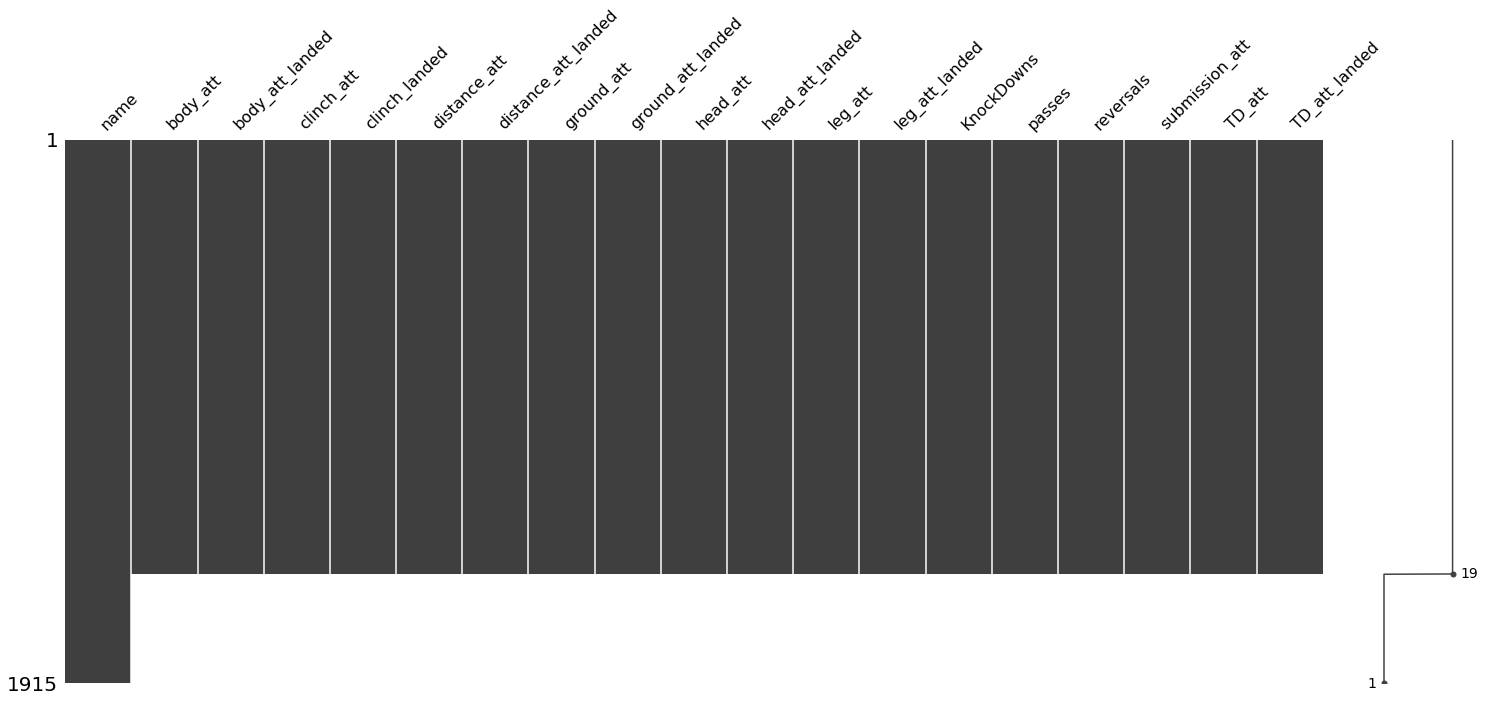

In [223]:
msno.matrix(fighters_skills)

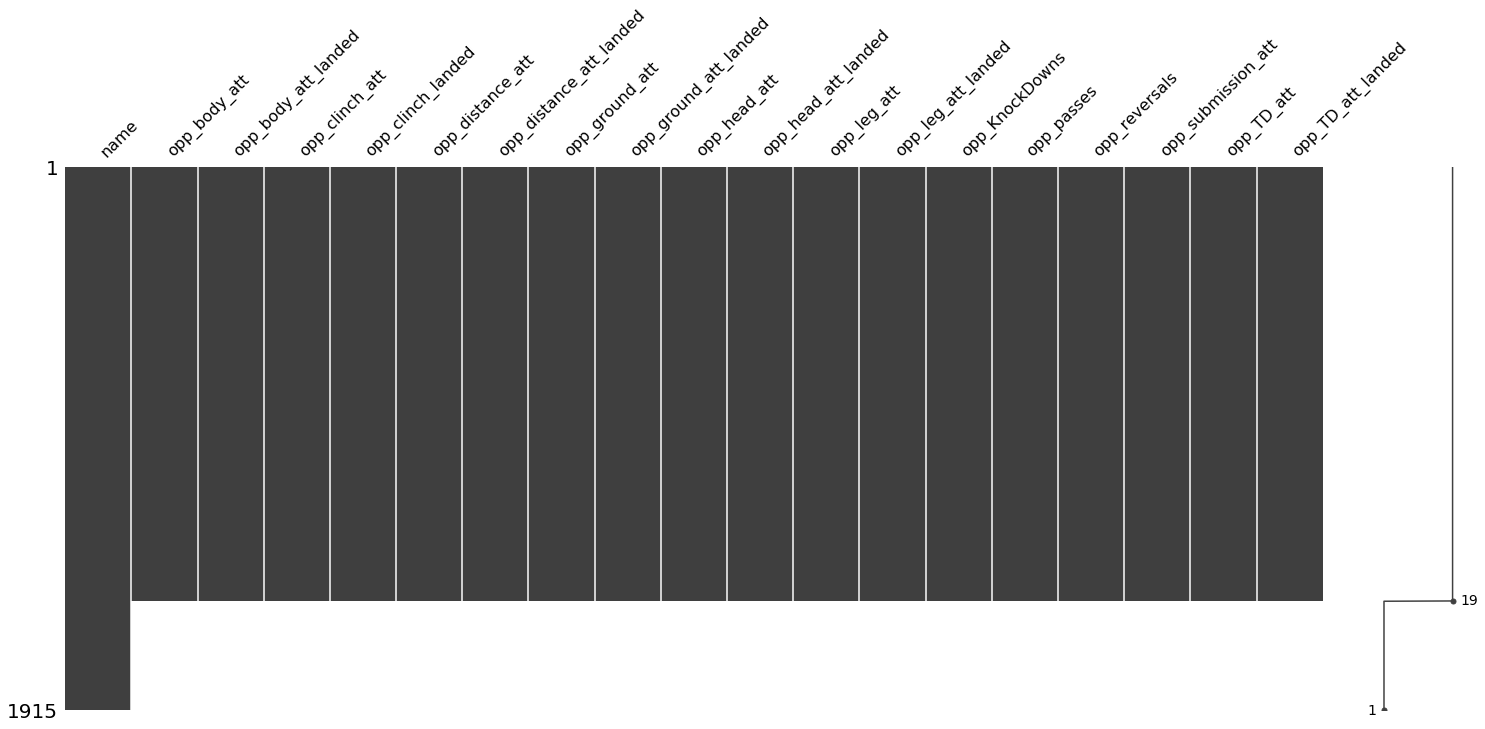

In [224]:
msno.matrix(fighters_defense)

In [229]:
fighters_skills[fighters_skills['body_att'].isnull()]

name  body_att  body_att_landed  clinch_att  clinch_landed  \
1530      Abu Azaitar       NaN              NaN         NaN            NaN   
1531   Chris Saunders       NaN              NaN         NaN            NaN   
1532   Rainy Martinez       NaN              NaN         NaN            NaN   
1533       Rex Holman       NaN              NaN         NaN            NaN   
1534     Derek Downey       NaN              NaN         NaN            NaN   
...               ...       ...              ...         ...            ...   
1910   Stefan Sekulic       NaN              NaN         NaN            NaN   
1911     Houston Dorr       NaN              NaN         NaN            NaN   
1912      Mark Hughes       NaN              NaN         NaN            NaN   
1913  John Polakowski       NaN              NaN         NaN            NaN   
1914      Mike Grundy       NaN              NaN         NaN            NaN   

      distance_att  distance_att_landed  ground_att  ground_att_landed  \
1530           NaN                  NaN         NaN                NaN   
1531           NaN                  NaN         NaN                NaN   
1532           NaN                  NaN         NaN                NaN   
1533           NaN                  NaN         NaN                NaN   
1534           NaN                  NaN         NaN                NaN   
...            ...                  ...         ...                ...   
1910           NaN                  NaN         NaN                NaN   
1911           NaN                  NaN         NaN                NaN   
1912           NaN                  NaN         NaN                NaN   
1913           NaN                  NaN         NaN                NaN   
1914           NaN                  NaN         NaN                NaN   

      head_att  head_att_landed  leg_att  leg_att_landed  KnockDowns  passes  \
1530       NaN              NaN      NaN             NaN         NaN     NaN   
1531       NaN              NaN      NaN             NaN         NaN     NaN   
1532       NaN              NaN      NaN             NaN         NaN     NaN   
1533       NaN              NaN      NaN             NaN         NaN     NaN   
1534       NaN              NaN      NaN             NaN         NaN     NaN   
...        ...              ...      ...             ...         ...     ...   
1910       NaN              NaN      NaN             NaN         NaN     NaN   
1911       NaN              NaN      NaN             NaN         NaN     NaN   
1912       NaN              NaN      NaN             NaN         NaN     NaN   
1913       NaN              NaN      NaN             NaN         NaN     NaN   
1914       NaN              NaN      NaN             NaN         NaN     NaN   

      reversals  submission_att  TD_att  TD_att_landed  
1530        NaN             NaN     NaN            NaN  
1531        NaN             NaN     NaN            NaN  
1532        NaN             NaN     NaN            NaN  
1533        NaN             NaN     NaN            NaN  
1534        NaN             NaN     NaN            NaN  
...         ...             ...     ...            ...  
1910        NaN             NaN     NaN            NaN  
1911        NaN             NaN     NaN            NaN  
1912        NaN             NaN     NaN            NaN  
1913        NaN             NaN     NaN            NaN  
1914        NaN             NaN     NaN            NaN  

[385 rows x 19 columns]

In [231]:
fighters_defense[fighters_defense['opp_body_att'].isnull()]

name  opp_body_att  opp_body_att_landed  opp_clinch_att  \
1530      Abu Azaitar           NaN                  NaN             NaN   
1531   Chris Saunders           NaN                  NaN             NaN   
1532   Rainy Martinez           NaN                  NaN             NaN   
1533       Rex Holman           NaN                  NaN             NaN   
1534     Derek Downey           NaN                  NaN             NaN   
...               ...           ...                  ...             ...   
1910   Stefan Sekulic           NaN                  NaN             NaN   
1911     Houston Dorr           NaN                  NaN             NaN   
1912      Mark Hughes           NaN                  NaN             NaN   
1913  John Polakowski           NaN                  NaN             NaN   
1914      Mike Grundy           NaN                  NaN             NaN   

      opp_clinch_landed  opp_distance_att  opp_distance_att_landed  \
1530                NaN               NaN                      NaN   
1531                NaN               NaN                      NaN   
1532                NaN               NaN                      NaN   
1533                NaN               NaN                      NaN   
1534                NaN               NaN                      NaN   
...                 ...               ...                      ...   
1910                NaN               NaN                      NaN   
1911                NaN               NaN                      NaN   
1912                NaN               NaN                      NaN   
1913                NaN               NaN                      NaN   
1914                NaN               NaN                      NaN   

      opp_ground_att  opp_ground_att_landed  opp_head_att  \
1530             NaN                    NaN           NaN   
1531             NaN                    NaN           NaN   
1532             NaN                    NaN           NaN   
1533             NaN                    NaN           NaN   
1534             NaN                    NaN           NaN   
...              ...                    ...           ...   
1910             NaN                    NaN           NaN   
1911             NaN                    NaN           NaN   
1912             NaN                    NaN           NaN   
1913             NaN                    NaN           NaN   
1914             NaN                    NaN           NaN   

      opp_head_att_landed  opp_leg_att  opp_leg_att_landed  opp_KnockDowns  \
1530                  NaN          NaN                 NaN             NaN   
1531                  NaN          NaN                 NaN             NaN   
1532                  NaN          NaN                 NaN             NaN   
1533                  NaN          NaN                 NaN             NaN   
1534                  NaN          NaN                 NaN             NaN   
...                   ...          ...                 ...             ...   
1910                  NaN          NaN                 NaN             NaN   
1911                  NaN          NaN                 NaN             NaN   
1912                  NaN          NaN                 NaN             NaN   
1913                  NaN          NaN                 NaN             NaN   
1914                  NaN          NaN                 NaN             NaN   

      opp_passes  opp_reversals  opp_submission_att  opp_TD_att  \
1530         NaN            NaN                 NaN         NaN   
1531         NaN            NaN                 NaN         NaN   
1532         NaN            NaN                 NaN         NaN   
1533         NaN            NaN                 NaN         NaN   
1534         NaN            NaN                 NaN         NaN   
...          ...            ...                 ...         ...   
1910         NaN            NaN                 NaN         NaN   
1911         NaN            NaN                 NaN      

385 fighters are missing defensive and offensive data values

In [232]:
indexes_of_missing_skills=fighters_skills[fighters_skills['body_att'].isnull()].index


In [234]:
fighters_career_stats.iloc[indexes_of_missing_skills]['number_of_fights'].value_counts()

1    385
Name: number_of_fights, dtype: int64

the fighters with missing defensive and offensive data values all have been in one match only. That may be the reason why they have missing values

In [231]:
list_missing_skills_defense=list(fighters_skills[fighters_skills['body_att'].isnull()][['name']])

the rows with missing values are dropped since there is no evidemt way to either replace or impute the missing values without damaging the integrity and purity of the data

In [236]:
fighters_defense=fighters_defense.dropna()
fighters_skills=fighters_skills.dropna()

the distribution of number of attacks landed and number of attacks gives us an approximation of the fighters' tendencies and which body parts are the hardest to hit

In [255]:
dist_strikes=['body_att','clinch_att','distance_att','ground_att','head_att',
              'leg_att','TD_att']
dist_landed=['body_att_landed','clinch_landed','distance_att_landed','ground_att_landed',
              'head_att_landed','leg_att_landed','TD_att_landed']

the head seems to be the most protected body part. this is not the most accurate way to find out though. later on the use of a more appropriate chart is needed

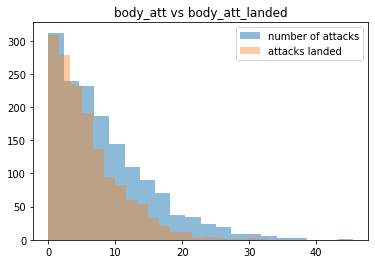

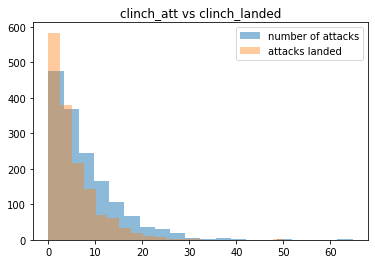

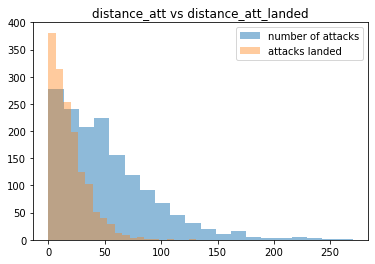

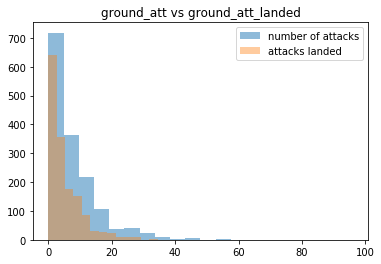

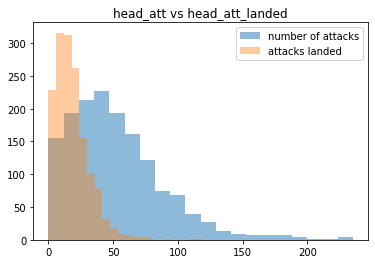

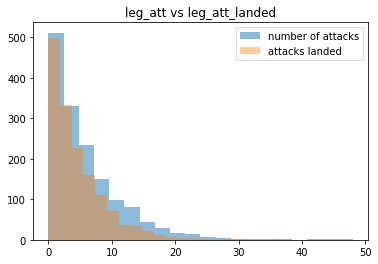

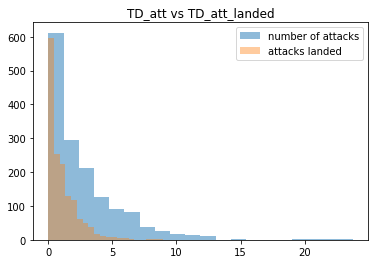

In [280]:
for i in range(len(dist_strikes)):
    plt.figure(i)
    plt.hist(x=fighters_skills[dist_strikes[i]],alpha=0.5,bins=20,label='number of attacks')
    plt.hist(x=fighters_skills[dist_landed[i]],alpha=0.4,bins=20,label='attacks landed')
    plt.legend(loc='upper right')
    plt.title(dist_strikes[i]+' vs '+ dist_landed[i])
    plt.show()

the dataset fighters_skills has columns expressing the number of strikes to a particular body part and also the number of strikes landed, meaning the ones that are significant and were not either blocked or dooged by the opponent, likewise for the fighters_defense dataset, the number of strikes received and the number of strikes landed, the difference in those two kind of columns describe the ability of a fighter to defend themselves against an opponent attack, both dataset fighters_skills and fighters_defense willhave respectively precisision of attacks and percentage of blocked attacks, the later columns will serve as a quantification of a fighters ability to hit particular body parts, or block opponents attack

the precision represents the ability of a fighter to landed a significant strike in specific scenarios and to certain body parts, the latter are, The head, the upper body and the legs, the former are, a clinch is a grapple hold where fighters are close to each other.A distance attack and a ground attack

In [281]:
def get_precision(cols):
    #takes the number of attacks and the number of attack landed and compute the percentage of attacks landed or the Precision
    attempts=cols[0]
    landed=cols[1]
    if attempts==0:
        return 0
    else:
        precision=(landed*100)/attempts
        return round(precision,3)

In [282]:
fighters_skills['body_att_precision']=fighters_skills[['body_att','body_att_landed']].apply(get_precision,axis=1)
fighters_skills['clinch_att_precision']=fighters_skills[['clinch_att','clinch_landed']].apply(get_precision,axis=1)
fighters_skills['distance_att_precision']=fighters_skills[['distance_att','distance_att_landed']].apply(get_precision,axis=1)
fighters_skills['groud_att_precision']=fighters_skills[['ground_att','ground_att_landed']].apply(get_precision,axis=1)
fighters_skills['head_att_precision']=fighters_skills[['head_att','head_att_landed']].apply(get_precision,axis=1)
fighters_skills['leg_att_precision']=fighters_skills[['leg_att','leg_att_landed']].apply(get_precision,axis=1)
fighters_skills['TD_att_precision']=fighters_skills[['TD_att','TD_att_landed']].apply(get_precision,axis=1)

similarly for blocking skills

In [283]:
def get_blocking_pct(cols):
    attempts=cols[0]
    landed=cols[1]
    if attempts==0:
        return 0
    else:
        blocked=attempts-landed
        blocking_pct=(blocked*100)/attempts
        return round(blocking_pct,3)


In [284]:
fighters_defense['body_blocked_pct']=fighters_defense[['opp_body_att','opp_body_att_landed']].apply(get_blocking_pct,axis=1)
fighters_defense['clinch_blocked_pct']=fighters_defense[['opp_clinch_att','opp_clinch_landed']].apply(get_blocking_pct,axis=1)
fighters_defense['distance_blocked_pct']=fighters_defense[['opp_distance_att','opp_distance_att_landed']].apply(get_blocking_pct,axis=1)
fighters_defense['ground_blocked_pct']=fighters_defense[['opp_ground_att','opp_ground_att_landed']].apply(get_blocking_pct,axis=1)
fighters_defense['head_blocked_pct']=fighters_defense[['opp_head_att','opp_head_att_landed']].apply(get_blocking_pct,axis=1)
fighters_defense['leg_blocked_pct']=fighters_defense[['opp_leg_att','opp_leg_att_landed']].apply(get_blocking_pct,axis=1)
fighters_defense['TD_att_blocked_pct']=fighters_defense[['opp_TD_att','opp_TD_att_landed']].apply(get_blocking_pct,axis=1)


In [239]:
fighters_skills_list=list(fighters_skills.columns[1:])

In [285]:
fighters_skills

name  body_att  body_att_landed  clinch_att  clinch_landed  \
0          Jim Miller     7.780            5.053       9.288          5.346   
1      Donald Cerrone    14.035           10.440       5.304          3.189   
2     Jeremy Stephens     7.849            5.750       4.351          3.525   
3     Andrei Arlovski     2.653            1.759       6.131          3.759   
4     Michael Bisping     9.886            7.884      11.479          7.542   
...               ...       ...              ...         ...            ...   
1525      Amar Suloev     5.000            2.000       0.000          0.000   
1526         Jeff Cox     0.000            0.000       0.000          0.000   
1527       John Cofer    18.000           11.000       8.000          5.000   
1528   Aaron Phillips    14.000           12.000       6.000          3.000   
1529  Ansar Chalangov     0.000            0.000       1.000          1.000   

      distance_att  distance_att_landed  ground_att  ground_att_landed  \
0           52.621               15.552        12.0                7.0   
1           77.309               37.494         7.0                5.0   
2           48.906               17.322        17.0               10.0   
3           41.067               15.096         2.0                1.0   
4           84.008               29.174        14.0                8.0   
...            ...                  ...         ...                ...   
1525        69.000               26.000         0.0                0.0   
1526         4.000                0.000         0.0                0.0   
1527        93.000               31.000         0.0                0.0   
1528        26.000                9.000         8.0                6.0   
1529         0.000                0.000         1.0                1.0   

      head_att  head_att_landed  leg_att  leg_att_landed  KnockDowns  passes  \
0       59.913           17.931    6.216           5.063       0.158   2.768   
1       58.687           20.472   16.646          14.279       0.439   1.466   
2       54.561           19.537    7.791           5.609       0.446   0.312   
3       36.954           11.739    9.326           6.465       0.471   0.148   
4       94.655           32.296    5.195           4.531       0.391   1.375   
...        ...              ...      ...             ...         ...     ...   
1525    53.000           14.000   11.000          10.000       0.000   0.000   
1526     4.000            0.000    0.000           0.000       0.000   0.000   
1527    77.000           20.000    6.000           5.000       0.000   1.000   
1528    23.000            5.000    3.000           1.000       0.000   1.000   
1529     1.000            1.000    1.000           1.000       0.000   1.000   

      reversals  submission_att  TD_att  TD_att_landed  body_att_precision  \
0         0.205           1.963   3.724          1.849              64.949   
1         0.062           0.386   1.816          0.842              74.385   
2         0.541           0.419   2.218          1.089              73.258   
3         0.005           0.418   0.444          0.205              66.302   
4         0.191           0.600   2.477          1.408              79.749   
...         ...             ...     ...            ...                 ...   
1525      0.000           0.000   0.000          0.000              40.000   
1526      0.000           0.000   1.000          1.000               0.000   
1527      0.000           0.000   4.000          2.000              61.111   
1528      1.000           1.000   0.000          0.000              85.714   
1529      1.000           2.000   2.000          0.000               0.000   

      clinch_att_precision  distance_att_precision  groud_att_precision  \
0                   57.558                  29.555               58.333   
1                   60.124                  48.499               71.429   
2                   81.016                  35.419      

a clinch situation is helpful when a fighter is threatened by the distance attacks of the opponent and want to reduce the distance in order to even the reach advantage. *Analytical question*: is there a relationship between the reach of a fighter and the tendency to get into a clinch?

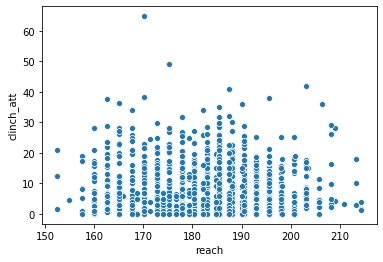

In [290]:
sns.scatterplot(fighters_physical_attributes['reach'],fighters_skills['clinch_att'])

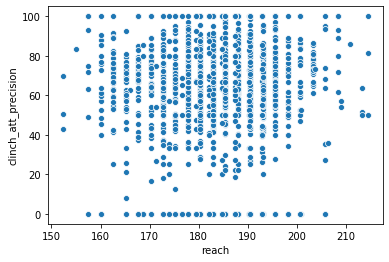

In [293]:
sns.scatterplot(fighters_physical_attributes['reach'],fighters_skills['clinch_att_precision'])

there is no evidence to support the assumption that there is a linear relationship between the reach and the tendency to go into a clinch.

in order to plot the defensive and offensive skills of fighters, the precision and blocking percentage. The appropriate chart would be a Radar Chart or Kiviat diagram due to its ability to represent multiple variables in a 2D chart

In [579]:
def plot_defensive_offensive_skills(name):
    #this function takes a fighters name and return 4 charts, the first one is the fighters precision,
    #the second is the fighters defensive skills, the third chart represents the number of different attacks
    #the last one represents the number of special techniques
    
    #labels that will be displayed on the radii or the spokes for first chart
    labels_skills=['body_att_precision','clinch_att_precision','distance_att_precision',
                      'groud_att_precision','head_att_precision','leg_att_precision','TD_att_precision']
    index_of_name=fighters_skills.loc[fighters_skills['name']==name].index
    
    #query to obtain the r or radii values for a given name
    r_skills=fighters_skills.iloc[index_of_name[0]]
    #creating a view or a placeholder which is a row that has the precisions of a given fighter
    view_skills=list(r_skills[labels_skills])
    
    #labels for the second chart
    labels_defense=['body_blocked_pct','clinch_blocked_pct','distance_blocked_pct',
                                     'ground_blocked_pct','head_blocked_pct','leg_blocked_pct',
                                     'TD_att_blocked_pct']
    #query to obtain the r values for the fighter with the provided name
    r_defense=fighters_defense.iloc[index_of_name[0]]
    #row or slice of the dataset where the name is equal to the given name, this row contains
    #the defensive values, conversion to a list is necessary for plotly
    view_defense=list(r_defense[labels_defense])

    #creating a fig with 4 subplot
    fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, horizontal_spacing=0.2)

    #first chart : precision of strikes
    fig.add_trace(go.Scatterpolar(
            r = view_skills,
            theta = labels_skills,
            marker_symbol = "square",
            fill='toself'
        ), 1, 1)
    #second chart: defensive skills
    fig.add_trace(go.Scatterpolar(
            r = view_defense,
            theta = labels_defense,
            marker_symbol = "circle",
            fill='toself'
        ), 1, 2)
   

    labels_number_attacks=['body_att','clinch_att','distance_att','ground_att','head_att','leg_att',
                          'TD_att']
    view_number_attacks=list(r_skills[labels_number_attacks])
    labels_number_attacks_landed=['body_att_landed','clinch_att_landed','distance_att_landed',
                                   'ground_att_landed','head_att_landed','leg_att_landed','TD_att_landed']
    view_number_attacks_landed=list(r_skills[labels_number_attacks_landed])
    
    #third chart on the bottom left, is the number of attacks and the number of attacks landed overlapping
    
    fig.add_trace(go.Scatterpolar(
            r = view_number_attacks,
            theta = labels_number_attacks,
            marker_symbol = "circle",
            fill='toself',
            name='n_attacks'
        ), 2, 1)
    fig.add_trace(go.Scatterpolar(
            r = view_number_attacks_landed,
            theta = labels_number_attacks,
            marker_symbol = "circle",
            fill='toself',
            name='n_landed'
        ), 2, 1)
    
    labels_advanced_techniques=['KnockDowns','passes','reversals','submission_att']
    view_advanced_techniques=list(r_skills[labels_advanced_techniques])
    #fourth chart represents the special techniques used by the fighter
    fig.add_trace(go.Scatterpolar(
            r = view_advanced_techniques,
            theta = labels_advanced_techniques,
            marker_symbol = "circle",
            fill='toself',
        ), 2, 2)
    
    #tweaking the parameters of each radar chart
    fig.update_layout(
        title={'text': name+" Precision, defense skills, number of attacks and special techniques",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        polar = dict(
          radialaxis_range = [0,100],
          angularaxis_thetaunit = "radians"
        ),
        polar2 = dict(
          radialaxis_range = [0,100],
          angularaxis_thetaunit = "radians"
        ),
        polar3=dict(
          
          angularaxis_thetaunit = "radians",
          
        ),
        polar4 = dict(
          angularaxis_thetaunit = "radians"
        ),

        showlegend = False
    )

    fig.show()


the radar charts illustrate important informations regarding a fighter's offensive and defensive skills. 
from the radar plot we can make these observations:
1- As hypothesized earlier the head is the most protected body part and the head attacks precision is likely to be the lowest.
2- attacks on legs tend to be neglected because they are not as harmful as attacks on other body parts
3-The most common attacks are distance attacks and head attacks.


In [583]:
plot_defensive_offensive_skills(list_fighters[0])

to understand the tendencies of fighters we compare and contrast the defensive and offensive skills of fighters

In [311]:
def comparison_precision(list_names):
    #this function takes a list of fighters and plot their precisions on the same radar chart
    index_names=list()
    r_skills=list()
    labels_skills=['body_att_precision','clinch_att_precision','distance_att_precision',
                      'groud_att_precision','head_att_precision','leg_att_precision','TD_att_precision']
    for name in list_names:
#retrieving the index of the fighters and storing them in index_names list to loop through them
        index_names.append(fighters_skills.loc[fighters_skills['name']==name].index)
        index_name=list(index_names)
#retrieving the row from fighters_skills with the corresponding name and storing in in the r_skills list
#r_skills is a list of lists and each element contains the radii values of a fighter
        r_skills.append(fighters_skills.iloc[fighters_skills.loc[fighters_skills['name']==name].index])

    fig=go.Figure()
#for each fighter in the list of names a radar chart is created using the values of r_skills at each index
    for row in range(0,len(r_skills)):
        r_view=r_skills[row][labels_skills]
        r_view=r_view.values[0]
        fig.add_trace(go.Scatterpolar(
            r=r_view,
            theta=labels_skills,
            name=list_names[row],
            
            
        ))
    fig.update_layout(
    title={'text': 'comparison of {} fighters precisions'.format(len(list_names)),
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    )
    fig.show()

        

In [312]:
def comparison_defense(list_names):
#same function as comparison_precision but for defensive skills
    index_names=list()
    r_defense=list()
    labels_skills=['body_blocked_pct','clinch_blocked_pct','distance_blocked_pct',
                   'ground_blocked_pct','head_blocked_pct','leg_blocked_pct','TD_att_blocked_pct']
    for name in list_names:
        index_names.append(fighters_defense.loc[fighters_defense['name']==name].index)
        index_name=list(index_names)
        r_defense.append(fighters_defense.iloc[fighters_defense.loc[fighters_defense['name']==name].index])

    fig=go.Figure()
    
    for row in range(0,len(r_defense)):
        r_view=r_defense[row][labels_skills]
        r_view=r_view.values[0]
        fig.add_trace(go.Scatterpolar(
            r=r_view,
            theta=labels_skills,
            name=list_names[row]
            
            
        ))
    fig.update_layout(
    title={'text': 'comparison of {} fighters defenses'.format(len(list_names)),
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    )
    fig.show()


comparing the precisions of 10 fighters

In [316]:
comparison_precision(list_fighters[:10])

the shapes are approximately similar to each others except for some variations especialy on the Takedowns att precisions. the obtention of similar shapes indicates that fighters follow the same tendencies or strategies in their attacks.

comparing the defensive skills of 10 fighters

In [317]:
comparison_defense(list_fighters[:10])

similar finding with the defensive skills, the shapes are similar and that also indicates the fighters tendencies and strategies are the same.


note that the rows are ordered by the number of fighters, therefore, the fighters with more experience are at the top of the dataset. do tendencies and strategies change with experience?

to find out we plot progressively ever 50 fighters from the top of the dataset to the bottom

In [338]:
step=50
for batch in range(0,1500,50):
    limit=batch+step
    comparison_precision(list_fighters[batch:limit])

In [340]:
step=50
for batch in range(0,1500,50):
    limit=batch+step
    comparison_defense(list_fighters[batch:limit])

the shapes change consistently but the core remains roughly the same, this indicates that no matter the experience, the basic strategy remains the same, however, the more fighters with more experience have nearly the same defensive and offensive strategies.

the most common fighting strategy is to protect the head, an attack on the head could knockout the opponent and therefore put an end to the match. are the fighters with good head attacks precision more likely to win in general and to win specifically by KO?

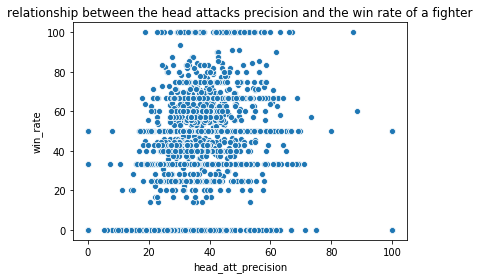

In [353]:
sns.scatterplot(fighters_skills['head_att_precision'],fighters_career_stats['win_rate'])
plt.title('relationship between the head attacks precision and the win rate of a fighter')
plt.show()

the plot indicates that there is no linear relationship between the precision of head attacks and the win rate of a fighter

In [351]:
temp=pd.DataFrame()
temp['head_att_precision']=fighters_skills['head_att_precision']
temp['win_rate']=fighters_career_stats['win_rate']
temp.corr()


head_att_precision  win_rate
head_att_precision            1.000000  0.338399
win_rate                      0.338399  1.000000

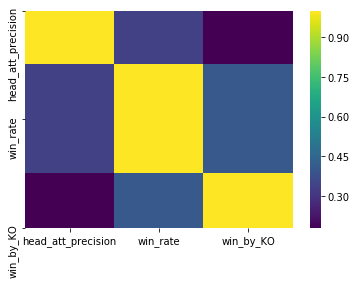

In [584]:
sns.heatmap(temp.corr(),cbar=True,cmap='viridis',yticklabels=True)

there is indeed a correlation between the precision of head attack and the win rate but it is weak and insignificant.

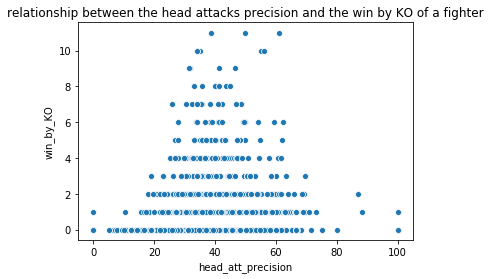

In [355]:
sns.scatterplot(fighters_skills['head_att_precision'],fighters_career_stats['win_by_KO'])
plt.title('relationship between the head attacks precision and the win by KO of a fighter')
plt.show()

no linear relationship between head attacks precision and win by KO

In [356]:
temp['win_by_KO']=fighters_career_stats['win_by_KO']
temp.corr()

head_att_precision  win_rate  win_by_KO
head_att_precision            1.000000  0.338399   0.180233
win_rate                      0.338399  1.000000   0.405222
win_by_KO                     0.180233  0.405222   1.000000

the correlation is also weak and insignificant.

*Conclusion*: there is no empirical evidence that proves the hypothesis that a fighter with high head attacks precision is more likely to win by KO

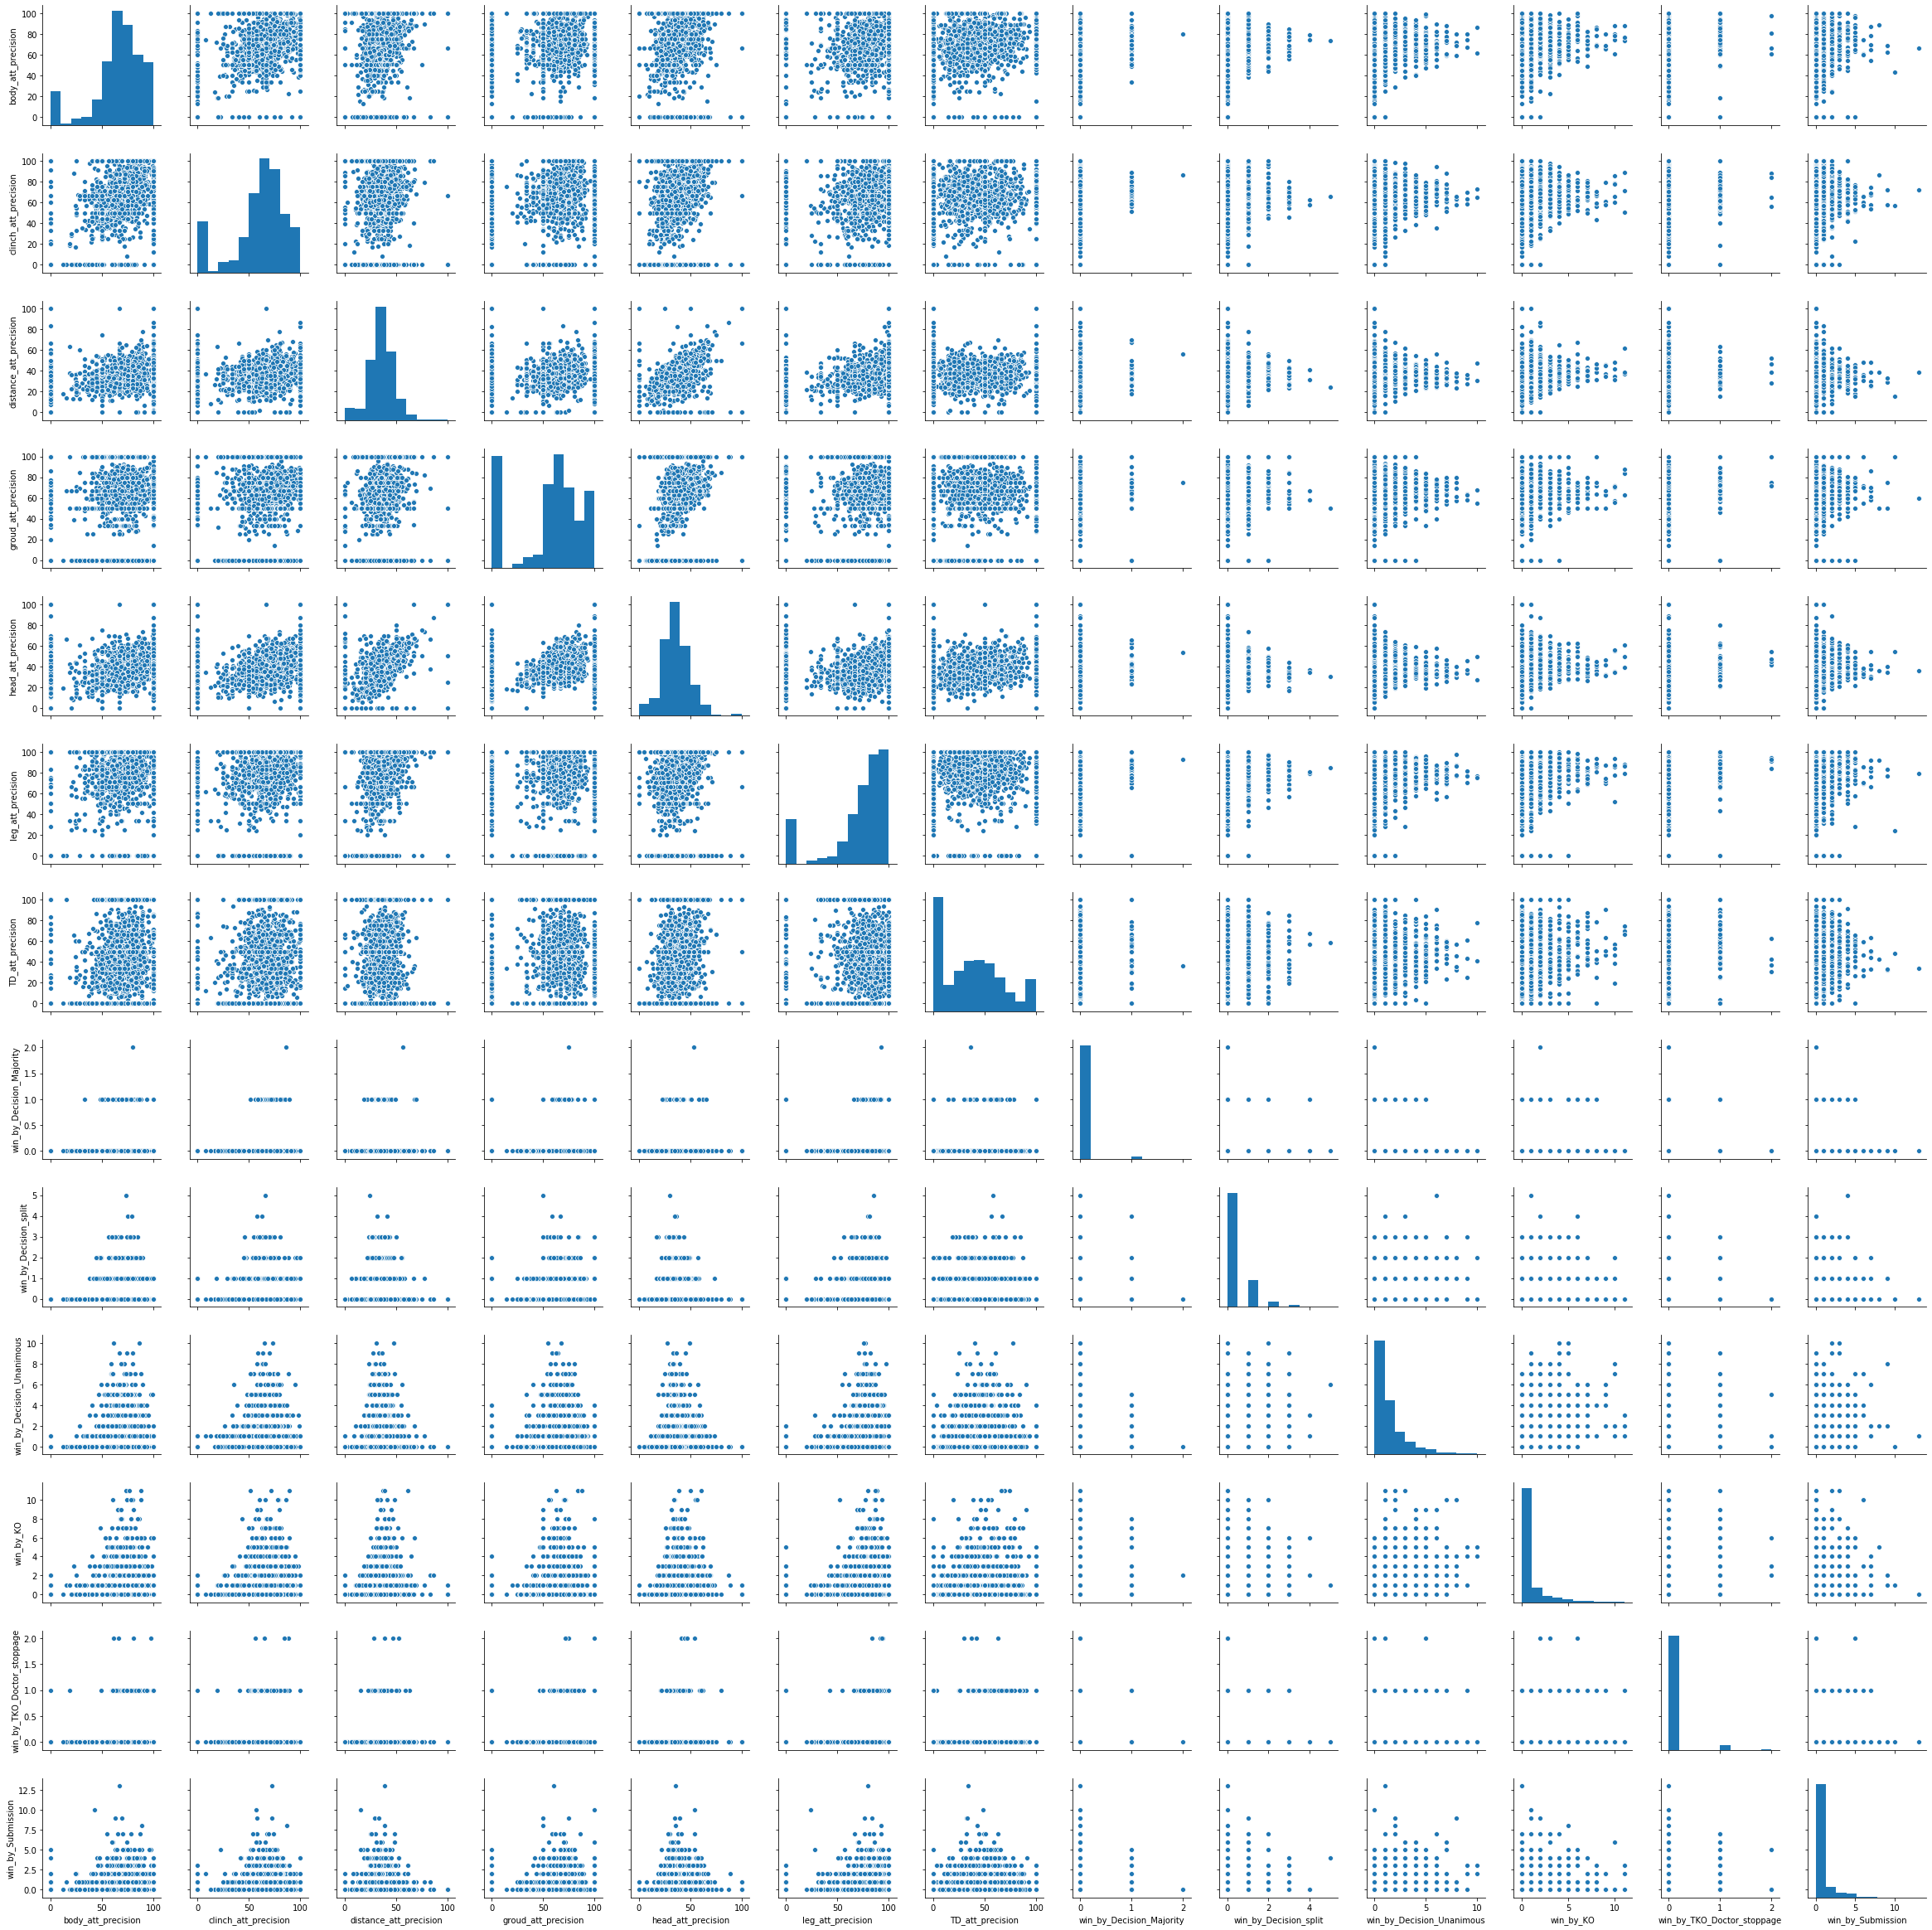

In [357]:
precision_list=['name','body_att_precision','clinch_att_precision','distance_att_precision',
                      'groud_att_precision','head_att_precision','leg_att_precision','TD_att_precision']
win_by_list=['name','win_by_Decision_Majority','win_by_Decision_split','win_by_Decision_Unanimous',
                                   'win_by_KO','win_by_TKO_Doctor_stoppage','win_by_Submission']
temp_precision=fighters_skills[precision_list]
temp_win_by=fighters_career_stats.iloc[temp_precision.index]
temp_win_by=temp_win_by[win_by_list]
temp_precision_win_by=pd.merge(left=temp_precision,right=temp_win_by,left_on='name',right_on='name')
temp_precision_win_by.drop(['name'],inplace=True,axis=1)

sns.pairplot(temp_precision_win_by)

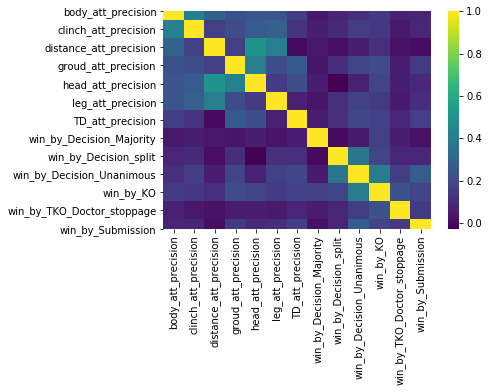

In [358]:
sns.heatmap(temp_precision_win_by.corr(),yticklabels=True,cmap='viridis',cbar=True)

the pairplot grid and the correlation heatmap show that there is no direct relationship between the precision of attacks on different body parts and the different scenarios to win, therefore, it is determined that the intrinsic relationship between a fighter's precision and how well they perform is more complicated than the hypothesis suggests

the next step is to get the overall precision and defense score for each fighter, by taking the average of the precisions. If not for the previous findings the overall precision/defense score would be calculated by assigning coefficients of importance to the precision as opposed to taking the average. because protecting or hitting the head is more important than the legs. however the previous findings do not support this assumptions and therefore we will take the average

In [362]:
def get_fighters_overall_precision_score(cols):
    #computes the average of the columns representing the precisions
    sum_of_cols=0
    score=0
    for col in cols:
        sum_of_cols+=col
    score=sum_of_cols/len(cols)
    return round(score,2)
    

In [364]:
fighters_skills['overall_precision_score']=fighters_skills[['body_att_precision','clinch_att_precision',
                                                    'distance_att_precision','groud_att_precision',
                                                    'head_att_precision','leg_att_precision',
                                                    'TD_att_precision']].apply(get_fighters_overall_precision_score,axis=1)

In [365]:
def get_fighters_overall_defense_score(cols):
    sum_of_cols=0
    score=0
    for col in cols:
        sum_of_cols+=col
    score=sum_of_cols/len(cols)
    return round(score,2)
    

In [367]:
fighters_defense['overall_defense_score']=fighters_defense[['body_blocked_pct','clinch_blocked_pct',
                                                    'distance_blocked_pct','ground_blocked_pct',
                                                    'head_blocked_pct','leg_blocked_pct',
                                                    'TD_att_blocked_pct']].apply(get_fighters_overall_defense_score,axis=1)

the next step is to create a final dataset in which the most important feature of the 4 first datasets will be regrouped 

from fighters_career_stats the features number_of_fights, win_rate, number of victories, longest_win streak and career_length are taken.


from fighters_defense and fighters_skills the overall scores were taken

from fighters_physical attributes the height, reach, weight and gender are taken

In [387]:
fighters_summary=pd.DataFrame()
fighters_summary['name']=fighters_skills['name']
temp_career_stats=fighters_career_stats.iloc[fighters_summary.index][['name','number_of_fights','win_rate','longest_win_streak','career_length_in_years','victories']]

fighters_summary=pd.merge(left=fighters_summary,right=temp_career_stats,left_on='name',right_on='name')
fighters_summary
fighters_summary['overall_precision_score']=fighters_skills['overall_precision_score']
fighters_summary['overall_defense_score']=fighters_defense['overall_defense_score']
fighters_summary
temp_physical_attributes=fighters_physical_attributes.iloc[fighters_summary.index][['name','height','reach','weight_kg','gender']]

fighters_summary=pd.merge(left=fighters_summary,right=temp_physical_attributes,left_on='name',right_on='name')
fighters_summary

name number_of_fights  win_rate  longest_win_streak  \
0          Jim Miller               32     59.38                 7.0   
1      Donald Cerrone               32     71.88                 8.0   
2     Jeremy Stephens               30     50.00                 3.0   
3     Andrei Arlovski               29     55.17                 7.0   
4     Michael Bisping               29     68.97                 5.0   
...               ...              ...       ...                 ...   
1525      Amar Suloev                2      0.00                 0.0   
1526         Jeff Cox                2      0.00                 0.0   
1527       John Cofer                2      0.00                 0.0   
1528   Aaron Phillips                2      0.00                 0.0   
1529  Ansar Chalangov                2      0.00                 0.0   

      career_length_in_years  victories  overall_precision_score  \
0                      10.53         19                    53.06   
1                       8.34         23                    60.21   
2                      11.78         15                    57.92   
3                      18.45         16                    51.66   
4                      11.43         20                    59.36   
...                      ...        ...                      ...   
1525                    0.33          0                    27.86   
1526                    0.81          0                    14.29   
1527                    0.54          0                    45.18   
1528                    0.25          0                    42.91   
1529                    0.38          0                    57.14   

      overall_defense_score  height    reach  weight_kg  gender  
0                     44.59  172.72  180.340     70.215       1  
1                     50.31  185.42  185.420     70.215       1  
2                     44.09  172.72  180.340     65.685       1  
3                     49.52  190.50  195.580    108.720       1  
4                     53.09  185.42  190.500     83.805       1  
...                     ...     ...      ...        ...     ...  
1525                  43.67  175.26  179.385     82.899       1  
1526                  11.43  177.80  182.078     70.215       1  
1527                  52.74  175.26  185.420     70.215       1  
1528                  42.86  175.26  177.800     61.155       1  
1529                  11.48  175.26  179.385     77.010       1  

[1530 rows x 12 columns]

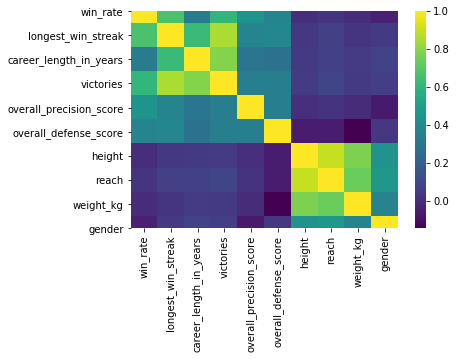

In [388]:
sns.heatmap(fighters_summary.corr(),cbar=True,yticklabels=True,cmap='viridis')
plt.show()

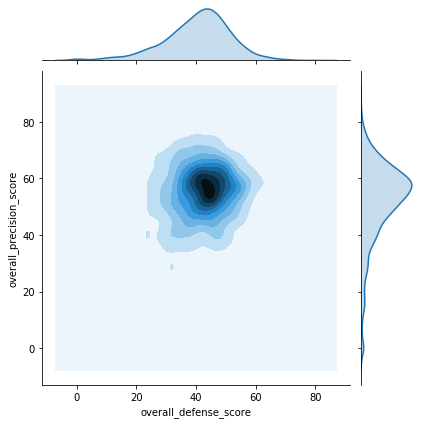

In [389]:
sns.jointplot(fighters_summary['overall_defense_score'],fighters_summary['overall_precision_score'],kind='kde')

In [390]:
fighters_summary[['overall_defense_score','overall_precision_score']].describe()

overall_defense_score  overall_precision_score
count            1530.000000              1530.000000
mean               40.577725                51.836523
std                11.046318                14.206018
min                 0.000000                 0.000000
25%                34.660000                46.085000
50%                41.860000                54.765000
75%                47.590000                60.770000
max                80.030000                84.890000

fighters tend to be on the offensive more than on the defensive. the best defense is a good offense

what are the best phyisical attributes for a fighter?

# Modeling the data

building a Linear Regression to predict the win rate of a fighter.

In [435]:
dependant_variable=fighters_summary['win_rate']
predictors=fighters_summary[['career_length_in_years',
                             'overall_precision_score',
                             'overall_defense_score','height','reach','weight_kg','gender']]

Linear Regression uses gradient descent to find the best fit, and therefore it is affected by the scale of the dataset.

In [436]:
from sklearn.preprocessing import StandardScaler

In [437]:
scaler=StandardScaler()

In [438]:
scaler.fit(predictors)
scaled_predictors=scaler.transform(predictors)
scaled_predictors
scaled_predict=pd.DataFrame(data=scaled_predictors,columns=['career_length_in_years',
                             'overall_precision_score',
                             'overall_defense_score','height','reach','weight_kg','gender'])
scaled_predict

career_length_in_years  overall_precision_score  overall_defense_score  \
0                   2.428579                 0.086152               0.363342   
1                   1.708383                 0.589624               0.881330   
2                   2.839649                 0.428372               0.318063   
3                   5.033121                -0.012430               0.809790   
4                   2.724549                 0.529771               1.133080   
...                      ...                      ...                    ...   
1525               -0.925756                -1.688324               0.280029   
1526               -0.767905                -2.643865              -2.639545   
1527               -0.856697                -0.468724               1.101385   
1528               -0.952065                -0.628568               0.206677   
1529               -0.909314                 0.373448              -2.635017   

        height     reach  weight_kg    gender  
0    -0.706491 -0.267736  -0.412148  0.296974  
1     0.758226  0.230074  -0.412148  0.296974  
2    -0.706491 -0.267736  -0.688116  0.296974  
3     1.344112  1.225693   1.933580  0.296974  
4     0.758226  0.727884   0.415756  0.296974  
...        ...       ...        ...       ...  
1525 -0.413547 -0.361320   0.360562  0.296974  
1526 -0.120604 -0.097422  -0.412148  0.296974  
1527 -0.413547  0.230074  -0.412148  0.296974  
1528 -0.413547 -0.516641  -0.964085  0.296974  
1529 -0.413547 -0.361320   0.001804  0.296974  

[1530 rows x 7 columns]

In [439]:
X_train, X_test, y_train, y_test = train_test_split(scaled_predict, dependant_variable, test_size=0.33, random_state=42)

In [585]:
x=sm.add_constant(X_train)

In [441]:
model=sm.OLS(y_train,x.astype(float)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     58.45
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           1.70e-70
Time:                        17:55:58   Log-Likelihood:                -4672.5
No. Observations:                1025   AIC:                             9361.
Df Residuals:                    1017   BIC:                             9400.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      41.7153      0.725     57.562      0.000      40.293      43.137
career_length_in_years      4.1343      0.746      5.543      0.000       2.671       5.598
overall_precision_score     9.2185      0.811     11.368      0.000       7.627      10.810
overall_defense_score       5.6644      0.813      6.964      0.000       4.068       7.261
height                     -2.9125      1.787     -1.630      0.103      -6.419       0.594
reach                       4.3524      1.715      2.537      0.011       0.986       7.718
weight_kg                   0.1275      1.196      0.107      0.915      -2.220       2.475
gender                     -1.8002      0.845     -2.132      0.033      -3.457      -0.143
==============================================================================
Omnibus:                       28.651   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.104
Skew:                           0.381   Prob(JB):                     1.76e-07
Kurtosis:                       3.383   Cond. No.                         5.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

the variables height and weight_kg have a p-value that exceeds 0.05 and are therefore insignificant and add no insights to the linear regression

In [521]:
dependant_variable=fighters_summary['win_rate'].values
predictors=fighters_summary[['career_length_in_years',
                             'overall_precision_score',
                             'overall_defense_score','reach','gender']]

In [522]:
scaler.fit(predictors)
scaled_predictors=scaler.transform(predictors)
scaled_predictors
scaled_predict=pd.DataFrame(data=scaled_predictors,columns=['career_length_in_years',
                             'overall_precision_score',
                             'overall_defense_score','reach','gender'])


In [523]:
x=sm.add_constant(scaled_predict)


In [524]:
model=sm.OLS(dependant_variable,x.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     121.8
Date:                Sun, 15 Dec 2019   Prob (F-statistic):          1.28e-108
Time:                        18:25:51   Log-Likelihood:                -6973.2
No. Observations:                1530   AIC:                         1.396e+04
Df Residuals:                    1524   BIC:                         1.399e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      41.1808      0.591     69.675      0.000      40.021      42.340
career_length_in_years      4.7495      0.636      7.466      0.000       3.502       5.997
overall_precision_score     8.5130      0.651     13.077      0.000       7.236       9.790
overall_defense_score       6.1422      0.646      9.503      0.000       4.874       7.410
reach                       1.5497      0.674      2.300      0.022       0.228       2.872
gender                     -1.8268      0.676     -2.703      0.007      -3.153      -0.501
==============================================================================
Omnibus:                       49.791   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.415
Skew:                           0.418   Prob(JB):                     9.26e-13
Kurtosis:                       3.412   Cond. No.                         1.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""